# Assignment 3: Active Learning in Neural Networks
## Machine Learning 441
Kellen Mossner
26024284@sun.ac.za

In [33]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef
)
import tqdm
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim

from NeuralNetwork import NeuralNetwork

import matplotlib.pyplot as plt
# IEEE dual-column specifications
column_width_pt = 241.14734  # Exact IEEE dual-column width
text_width_pt = 516.0        # Full text width (both columns + gap)

column_width_inches = column_width_pt / 72.27
text_width_inches = text_width_pt / 72.27

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,           # Base font size to match document
    "axes.labelsize": 10,      # x and y axis labels
    "axes.titlesize": 10,      # Plot title
    "xtick.labelsize": 10,      # x-axis tick labels (slightly smaller)
    "ytick.labelsize": 10,      # y-axis tick labels (slightly smaller)
    "legend.fontsize": 10,      # Legend text
    "figure.titlesize": 10,    # Figure title (if used)
    
    # Line and marker properties
    "lines.linewidth": 1.2,
    "lines.markersize": 4,
    "patch.linewidth": 0.5,
    
    # Grid properties
    "grid.linewidth": 0.5,
    "grid.alpha": 0.3,
    
    # Save properties
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.format": "pdf",
    "savefig.pad_inches": 0.02,
})

import scikit_posthocs as sp
from scipy.stats import rankdata, wilcoxon

In [2]:
# Data quality reports
def quality_report(df):
    """
    Generate a quality report for the DataFrame.
    """

    report_cts = df.describe(include=[np.number]).T
    report_cts["Cardinality"] = df.nunique()
    report_cts["Missing Percentage"] = (df.isnull().sum() / len(df)) * 100
    report_cts.rename(
        columns={
            "50%": "Median",
            "25%": "1st Qrt",
            "75%": "3rd Qrt",
            "mean": "Mean",
            "count": "Count",
            "max": "Max",
            "std": "Std Dev",
            "min": "Min",
        },
        inplace=True,
    )
    report_cts["Count"] = len(df)
    report_cts.reset_index(inplace=True)
    report_cts.rename(columns={"index": "Feature"}, inplace=True)

    categorical_cols = df.select_dtypes(include=["object"]).columns
    cat_data = []
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        total_count = len(df[col])
        mode = value_counts.index[0] if len(value_counts) > 0 else None
        mode_freq = value_counts.iloc[0] if len(value_counts) > 0 else 0
        mode_pct = (mode_freq / total_count * 100) if total_count > 0 else 0
        second_mode = value_counts.index[1] if len(value_counts) > 1 else None
        second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else 0
        second_mode_pct = (
            (second_mode_freq / total_count * 100) if total_count > 0 else 0
        )
        cat_data.append(
            {
                "Feature": col,
                "Count": total_count,
                "Missing Percentage": round(
                    (df[col].isnull().sum() / len(df)) * 100, 2
                ),
                "Unique": df[col].nunique(),
                "Mode": mode,
                "Mode Freq": mode_freq,
                "Mode %": round(mode_pct, 2),
                "2nd Mode": second_mode,
                "2nd Mode Freq": second_mode_freq,
                "2nd Mode %": round(second_mode_pct, 2),
                "Cardinality": df[col].nunique(),
            }
        )
    report_cat = pd.DataFrame(cat_data)

    # return both data quality reports
    return report_cts, report_cat

### Data Pre-processing: Classification Problems

In [3]:
# 1. Breast Cancer Dataset
classification1 = pd.read_csv('../data/breast_cancer.csv')
classification1.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
classification1.drop(columns=['Unnamed: 32'], inplace=True)  # drop empty column
X = classification1.drop(columns=['diagnosis', 'id'])
y = classification1['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
# No data quality issues
print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts()}")
print(f"Missing values: {X.isnull().sum().sum()}")

# Create 70-10-20 train-val-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.125, random_state=42, stratify=y_train1)

# Create 1 hot encoding for categorical response vectors
y_train1 = pd.get_dummies(y_train1).values
y_val1 = pd.get_dummies(y_val1).values
y_test1 = pd.get_dummies(y_test1).values
print(f"Response shape: {y_train1.shape}, {y_val1.shape}, {y_test1.shape}")

# Scale features
scaler1 = MinMaxScaler(feature_range=(-1, 1))
X_train1 = scaler1.fit_transform(X_train1)
X_val1 = scaler1.transform(X_val1)
X_test1 = scaler1.transform(X_test1)

Dataset shape: (569, 30)
Class distribution: diagnosis
0    357
1    212
Name: count, dtype: int64
Missing values: 0
Response shape: (398, 2), (57, 2), (114, 2)


In [5]:
# 2. Mobile Price Dataset
classification2 = pd.read_csv('../data/mobile.csv')
classification2.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0.0,1,0,7,0.6,188.0,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1.0,0,1,53,0.7,136.0,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1.0,2,1,41,0.9,145.0,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0.0,0,0,10,0.8,131.0,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0.0,13,1,44,0.6,141.0,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
report_cts, report_cat = quality_report(classification2)
report_cts.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,battery_power,3000,992.512333,526.848699,1.0,601.00,913.5,1432.25,1998.0,1727,0.0
1,blue,3000,416.500000,639.166930,0.0,0.00,1.0,895.00,1999.0,723,0.0
2,clock_speed,3000,1.186833,0.867291,0.0,0.50,1.0,1.90,3.0,27,0.0
3,dual_sim,3000,0.853300,0.795118,0.0,0.00,1.0,1.00,3.0,27,0.0
4,fc,3000,3.045333,3.980439,0.0,0.00,1.0,5.00,19.0,20,0.0
5,four_g,3000,1.878667,3.238432,0.0,0.00,1.0,1.00,19.0,20,0.0
6,int_memory,3000,21.526667,20.999181,0.0,1.00,16.0,40.00,64.0,65,0.0
7,m_dep,3000,11.551833,18.810166,0.1,0.40,0.8,18.00,64.0,73,0.0
8,mobile_wt,3000,93.671833,71.941799,0.1,0.80,109.0,156.00,200.0,131,0.0
9,n_cores,3000,49.517333,66.774816,1.0,4.00,7.0,109.25,200.0,129,0.0


In [7]:
X = classification2.drop(columns=['price_range'])
y = classification2['price_range']
# No data quality issues
print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts()}")
print(f"Missing values: {X.isnull().sum().sum()}")

# Create 70-10-20 train-val-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.125, random_state=42, stratify=y_train2)

# Create 1 hot encoding for categorical response vectors
y_train2 = pd.get_dummies(y_train2).values
y_val2 = pd.get_dummies(y_val2).values
y_test2 = pd.get_dummies(y_test2).values
print(f"Response shape: {y_train2.shape}, {y_val2.shape}, {y_test2.shape}")

# Scale features
scaler2 = MinMaxScaler(feature_range=(-1, 1))
X_train2 = scaler2.fit_transform(X_train2)
X_val2 = scaler2.transform(X_val2)
X_test2 = scaler2.transform(X_test2)

Dataset shape: (3000, 20)
Class distribution: price_range
1    1007
0     993
2     500
3     500
Name: count, dtype: int64
Missing values: 0
Response shape: (2100, 4), (300, 4), (600, 4)


In [8]:
# 3. Letter Recognition Dataset
classification3 = pd.read_csv('../data/letter_recognition.csv')
classification3.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [9]:
report_cts, report_cat = quality_report(classification3)
report_cts.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,x-box,20000,4.02355,1.913212,0.0,3.0,4.0,5.0,15.0,16,0.0
1,y-box,20000,7.03550,3.304555,0.0,5.0,7.0,9.0,15.0,16,0.0
2,width,20000,5.12185,2.014573,0.0,4.0,5.0,6.0,15.0,16,0.0
3,high,20000,5.37245,2.261390,0.0,4.0,6.0,7.0,15.0,16,0.0
4,onpix,20000,3.50585,2.190458,0.0,2.0,3.0,5.0,15.0,16,0.0
5,x-bar,20000,6.89760,2.026035,0.0,6.0,7.0,8.0,15.0,16,0.0
6,y-bar,20000,7.50045,2.325354,0.0,6.0,7.0,9.0,15.0,16,0.0
7,x2bar,20000,4.62860,2.699968,0.0,3.0,4.0,6.0,15.0,16,0.0
8,y2bar,20000,5.17865,2.380823,0.0,4.0,5.0,7.0,15.0,16,0.0
9,xybar,20000,8.28205,2.488475,0.0,7.0,8.0,10.0,15.0,16,0.0


In [10]:
report_cat.head(1)

,Feature,Count,Missing Percentage,Unique,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %,Cardinality
0,lettr,20000,0.0,26,U,813,4.06,D,805,4.03,26


In [11]:
label_encoder = LabelEncoder()
classification3['lettr'] = label_encoder.fit_transform(classification3['lettr'])

X = classification3.drop(columns=['lettr'])
y = classification3['lettr']

# No data quality issues
print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts()}")
print(f"Missing values: {X.isnull().sum().sum()}")

# Create 70-10-20 train-val-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.125, random_state=42, stratify=y_train3)

# Create 1 hot encoding for categorical response vectors
y_train3 = pd.get_dummies(y_train3).values
y_val3 = pd.get_dummies(y_val3).values
y_test3 = pd.get_dummies(y_test3).values
print(f"Response shape: {y_train3.shape}, {y_val3.shape}, {y_test3.shape}")

# Scale features
scaler3 = MinMaxScaler(feature_range=(-1, 1))
X_train3 = scaler3.fit_transform(X_train3)
X_val3 = scaler3.transform(X_val3)
X_test3 = scaler3.transform(X_test3)

Dataset shape: (20000, 16)
Class distribution: lettr
20    813
3     805
15    803
19    796
12    792
0     789
23    787
24    786
13    783
16    783
5     775
6     773
4     768
1     766
21    764
11    761
17    758
8     755
14    753
22    752
18    748
9     747
10    739
2     736
7     734
25    734
Name: count, dtype: int64
Missing values: 0
Response shape: (14000, 26), (2000, 26), (4000, 26)


### Data Pre-processing: Regression Problems

In [12]:
# 4. Boston Housing Dataset
regression1 = pd.read_csv('../data/housing.csv')
regression1.head() 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [13]:
report_cts, report_cat = quality_report(regression1)
report_cts.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,CRIM,506,3.611874,8.720192,0.00632,0.081900,0.253715,3.560263,88.9762,484,3.952569
1,ZN,506,11.211934,23.388876,0.00000,0.000000,0.000000,12.500000,100.0000,26,3.952569
2,INDUS,506,11.083992,6.835896,0.46000,5.190000,9.690000,18.100000,27.7400,76,3.952569
3,CHAS,506,0.069959,0.255340,0.00000,0.000000,0.000000,0.000000,1.0000,2,3.952569
4,NOX,506,0.554695,0.115878,0.38500,0.449000,0.538000,0.624000,0.8710,81,0.000000
5,RM,506,6.284634,0.702617,3.56100,5.885500,6.208500,6.623500,8.7800,446,0.000000
6,AGE,506,68.518519,27.999513,2.90000,45.175000,76.800000,93.975000,100.0000,348,3.952569
7,DIS,506,3.795043,2.105710,1.12960,2.100175,3.207450,5.188425,12.1265,412,0.000000
8,RAD,506,9.549407,8.707259,1.00000,4.000000,5.000000,24.000000,24.0000,9,0.000000
9,TAX,506,408.237154,168.537116,187.00000,279.000000,330.000000,666.000000,711.0000,66,0.000000


In [14]:
report_cat.head()

""


In [15]:
X = regression1.drop(columns=['MEDV'])
y = regression1['MEDV']

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
print(f"Dataset shape: {X.shape}")
print(f"Missing values: {np.isnan(X).sum()}")

# Create 70-10-20 train-val-test split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_train4, y_train4, test_size=0.125, random_state=42)

# Scale features
scaler4 = MinMaxScaler(feature_range=(-1, 1))
X_train4 = scaler4.fit_transform(X_train4)
X_val4 = scaler4.transform(X_val4)
X_test4 = scaler4.transform(X_test4)

# Scale target variable to output range of sigmoid activation function
y_scaler4 = MinMaxScaler(feature_range=(0, 1))
y_train4 = y_scaler4.fit_transform(y_train4.values.reshape(-1, 1))
y_val4 = y_scaler4.transform(y_val4.values.reshape(-1, 1))
y_test4 = y_scaler4.transform(y_test4.values.reshape(-1, 1))

Dataset shape: (506, 13)
Missing values: 0


In [16]:
# 5. Concrete Compressive Strength Dataset
regression2 = pd.read_csv('../data/concrete.csv')
regression2.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [17]:
report_cts, report_cat = quality_report(regression2)
report_cts.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,Cement,1030,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0,278,0.0
1,Blast Furnace Slag,1030,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4,185,0.0
2,Fly Ash,1030,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1,156,0.0
3,Water,1030,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0,195,0.0
4,Superplasticizer,1030,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2,111,0.0
5,Coarse Aggregate,1030,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0,284,0.0
6,Fine Aggregate,1030,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6,302,0.0
7,Age,1030,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0,14,0.0
8,Concrete compressive strength,1030,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6,845,0.0


In [18]:
report_cat.head()

""


In [19]:
X = regression2.drop(columns=['Concrete compressive strength'])
y = regression2['Concrete compressive strength']

# No data quality issues
print(f"Dataset shape: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

# Create 70-10-20 train-val-test split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train5, X_val5, y_train5, y_val5 = train_test_split(X_train5, y_train5, test_size=0.125, random_state=42)

# Scale features
scaler5 = MinMaxScaler(feature_range=(-1, 1))
X_train5 = scaler5.fit_transform(X_train5)
X_val5 = scaler5.transform(X_val5)
X_test5 = scaler5.transform(X_test5)

# Scale target variable to output range of sigmoid activation function
y_scaler5 = MinMaxScaler(feature_range=(0, 1))
y_train5 = y_scaler5.fit_transform(y_train5.values.reshape(-1, 1))
y_val5 = y_scaler5.transform(y_val5.values.reshape(-1, 1))
y_test5 = y_scaler5.transform(y_test5.values.reshape(-1, 1))

Dataset shape: (1030, 8)
Missing values: 0


In [20]:
# 6. Abalone Dataset
regression3 = pd.read_csv('../data/abalone.csv')
regression3.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [21]:
report_cts, report_cat = quality_report(regression3)
report_cts.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,Length,4177,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150,134,0.0
1,Diameter,4177,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500,111,0.0
2,Height,4177,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300,51,0.0
3,Whole weight,4177,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255,2429,0.0
4,Shucked weight,4177,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880,1515,0.0
5,Viscera weight,4177,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600,880,0.0
6,Shell weight,4177,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050,926,0.0
7,Rings,4177,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000,28,0.0


In [22]:
report_cat.head()

,Feature,Count,Missing Percentage,Unique,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %,Cardinality
0,Sex,4177,0.0,3,M,1528,36.58,I,1342,32.13,3


In [23]:
# Create dummy variables for categorical feature
regression3 = pd.get_dummies(regression3, columns=['Sex'], drop_first=True)
X = regression3.drop(columns=['Rings'])
y = regression3['Rings']

# No data quality issues
print(f"Dataset shape: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

# Create 70-10-20 train-val-test split
X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train6, X_val6, y_train6, y_val6 = train_test_split(X_train6, y_train6, test_size=0.125, random_state=42)

# Scale features
scaler6 = MinMaxScaler(feature_range=(-1, 1))
X_train6 = scaler6.fit_transform(X_train6)
X_val6 = scaler6.transform(X_val6)
X_test6 = scaler6.transform(X_test6)

# Scale target variable to output range of sigmoid activation function
y_scaler6 = MinMaxScaler(feature_range=(0, 1))
y_train6 = y_scaler6.fit_transform(y_train6.values.reshape(-1, 1))
y_val6 = y_scaler6.transform(y_val6.values.reshape(-1, 1))
y_test6 = y_scaler6.transform(y_test6.values.reshape(-1, 1))

Dataset shape: (4177, 9)
Missing values: 0


### Create the training loop for the neural network

In [24]:
def train_model(model, X_train, y_train, X_val, y_val, criterion=None, optimizer=None, num_epochs=100, batch_size=32, v=True):
    """
    Train the neural network model.
    """
    
    if criterion is None:
        criterion = nn.MSELoss()
    if optimizer is None:
        optimizer = optim.SGD(model.parameters())

    history = {'train_loss': [], 'val_loss': []}
    
    if v:
        epoch_pbar = tqdm.tqdm(range(num_epochs), desc="Training")
    else:
        epoch_pbar = range(num_epochs)

    for epoch in epoch_pbar:
        model.train()
        permutation = torch.randperm(X_train.size()[0])
        
        epoch_loss = 0.0
        num_batches = (X_train.size()[0] + batch_size - 1) // batch_size
        
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_epoch_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            history['val_loss'].append(val_loss)
        
        # Update progress bar with current metrics
        if v:
            epoch_pbar.set_postfix({
                "Train Loss": f"{avg_epoch_loss:.4f}", 
                "Val Loss": f"{val_loss:.4f}"
            })
    
    return model, history

In [25]:
def evaluate_model(model, X_test, y_test, problem="classification", v=True):
    """
    Evaluate the neural network model.
    """
    if problem == "classification":
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test)
            outputs = model(X_test_tensor)
            
            # one hot encoded categorical response vectors
            if isinstance(y_test, np.ndarray) and len(y_test.shape) > 1:
                # one hot encoded -> class labels
                y_true = np.argmax(y_test, axis=1)
                y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
            else:
                y_true = y_test
                y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
                
            accuracy = accuracy_score(y_true, y_pred)
            
            # Determine if binary or multiclass
            n_classes = len(np.unique(y_true))
            if n_classes == 2:
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
            else:
                precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
                recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
            
            mcc = matthews_corrcoef(y_true, y_pred)

        if v:
            print("\nEvaluation on test set:")
            print(f'Accuracy: {accuracy * 100:.2f}%')
            print(f'Precision: {precision:.4f}')
            print(f'Recall: {recall:.4f}')
            print(f'F1 Score: {f1:.4f}')
            print(f'Matthews Correlation Coefficient: {mcc:.4f}')
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred))
            print("Confusion Matrix:")
            print(confusion_matrix(y_true, y_pred))
        
        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall, 
            'f1_score': f1,
            'mcc': mcc
        }
    else:
        # Regression
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test)
            y_pred = model(X_test_tensor).cpu().numpy()
            y_true = y_test
            
            # Ensure shapes match TODO
            if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
                y_pred = y_pred.flatten()
            if len(y_true.shape) > 1 and y_true.shape[1] == 1:
                y_true = y_true.flatten()
            
            mse = mean_squared_error(y_true, y_pred)
            root_mse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            
        if v:
            print("\nEvaluation on test set:")
            print(f'Test MSE: {mse:.4f}')
            print(f"Test Root MSE: {root_mse:.4f}")
            print(f'Test MAE: {mae:.4f}')
            print(f'Test R-squared: {r2:.4f}')
        
        results = {
            'mse': mse,
            'root_mse': root_mse,
            'mae': mae,
            'r2_score': r2,
        }
    return results

In [26]:
def plot_history(history, loss="MSE"):
    """
    Plot training and validation loss over epochs.
    """
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'{loss} Loss')
    plt.legend()
    plt.show()

In [27]:
def training_pipeline(X, y, problem='classification', hidden_units=10, n_epochs=100, batch_size=32, learning_rate=0.001, momentum=0.9, weight_decay=1e-5, v=True):
    """
    Training pipeline for classification and regression tasks. 
    """
    # unzip data
    X_train, X_val, X_test = X
    y_train, y_val, y_test = y
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    if problem == "classification":
        y_train_tensor = torch.FloatTensor(y_train)
        y_val_tensor = torch.FloatTensor(y_val)
        n_output = y_train.shape[1]
    else:
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
        n_output = 1
  
    n_input = X_train.shape[1]
    n_hidden = hidden_units

    model = NeuralNetwork(n_input, n_hidden, n_output)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    trained_model, history = train_model(
        model, 
        X_train_tensor, 
        y_train_tensor, 
        X_val_tensor, 
        y_val_tensor, 
        criterion=criterion, 
        optimizer=optimizer, 
        num_epochs=n_epochs, 
        batch_size=batch_size,
        v=v
    )
    
    # Evaluate on test set
    results = evaluate_model(trained_model, X_test, y_test, problem=problem, v=v)
    if v:
        # Plot training and validation loss
        plot_history(history, "MSE")
    
    return trained_model, history, results

In [28]:
def grid_search_cv(param_grid, X_train, y_train, problem='classification', cv=5):
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))
    
    best_params = None
    best_score = -np.inf
    all_results = []
    
    if problem == 'classification':
        y = np.argmax(y_train, axis=1)
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    else:
        y = y_train
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for i, param_combo in enumerate(tqdm.tqdm(param_combinations, desc="Grid Search")):
        params = dict(zip(param_names, param_combo))
        
        cv_scores = []
        cv_val_losses = []
        cv_train_losses = []
        try:
            # Perform cross-validation
            for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y)):
                # Split data for this fold
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                if isinstance(y_train, np.ndarray) and len(y_train.shape) > 1:
                    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                else:
                    if hasattr(y_train, 'iloc'):
                        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                    else:
                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                X_fold = (X_fold_train, X_fold_val, X_fold_val)
                y_fold = (y_fold_train, y_fold_val, y_fold_val)
                
                _, history, results = training_pipeline(
                        X_fold, y_fold,
                        hidden_units=params['hidden_units'],
                        problem=problem,
                        n_epochs=params['n_epochs'],
                        batch_size=params['batch_size'],
                        learning_rate=params['learning_rate'],
                        momentum=params['momentum'],
                        weight_decay=params['weight_decay'],
                        v=False
                    )
                if problem == 'classification':
                    fold_score = results['f1_score']
                else:
                    fold_score = results['r2_score']
                
                cv_scores.append(fold_score)
                cv_val_losses.append(history['val_loss'][-1])
                cv_train_losses.append(history['train_loss'][-1])
            
            # Calculate mean and std of CV scores
            mean_score = np.mean(cv_scores)
            std_score = np.std(cv_scores)
            mean_val_loss = np.mean(cv_val_losses)
            mean_train_loss = np.mean(cv_train_losses)
            
            # Store results
            all_results.append({
                'params': params.copy(),
                'mean_score': mean_score,
                'std_score': std_score,
                'cv_scores': cv_scores,
                'mean_val_loss': mean_val_loss,
                'mean_train_loss': mean_train_loss
            })
            
            # Update best parameters based on mean CV score
            if mean_score > best_score:
                best_score = mean_score
                best_params = params.copy()
                
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
            continue
          
    return best_params, all_results

## Passive Learning

In [29]:
print(X_train1.shape)
print(X_train2.shape)
print(X_train3.shape)
print(X_train4.shape)
print(X_train5.shape)
print(X_train6.shape)

(398, 30)
(2100, 20)
(14000, 16)
(353, 13)
(721, 8)
(2923, 9)


#### Breast Cancer Classification

In [83]:
# # Hyper-parameter tuning
# param_grid = {
#     'hidden_units': [16],
#     'n_epochs': [200, 300, 500],
#     'batch_size': [16, 32],
#     'learning_rate': [0.1, 0.01],
#     'momentum': [0.8, 0.9],
#     'weight_decay': [0.0001, 0.00001]
# }

# best_params1, all_results1 = grid_search_cv(param_grid, X_train1, y_train1, problem='classification')
# print(best_params1)

# Grid Search: 100%|██████████| 48/48 [23:55<00:00, 29.90s/it]
# {'hidden_units': 16, 'n_epochs': 500, 'batch_size': 32, 'learning_rate': 0.1, 'momentum': 0.8, 'weight_decay': 0.0001}

Training: 100%|██████████| 500/500 [00:03<00:00, 153.33it/s, Train Loss=0.0158, Val Loss=0.0286]



Evaluation on test set:
Accuracy: 99.12%
Precision: 1.0000
Recall: 0.9762
F1 Score: 0.9880
Matthews Correlation Coefficient: 0.9812

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix:
[[72  0]
 [ 1 41]]


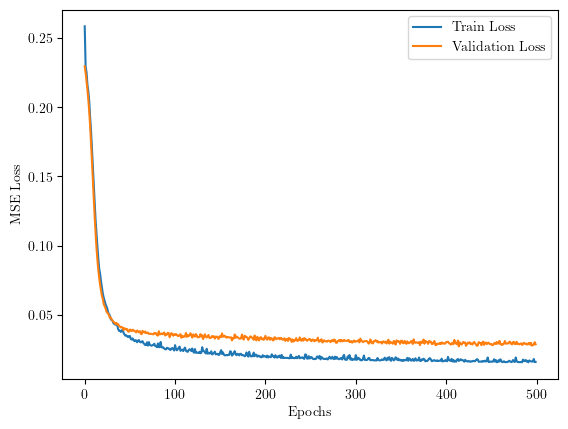

AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.9842 ± 0.0035
F1 Score:  0.9781 ± 0.0049
Precision: 1.0000 ± 0.0000
Recall:    0.9571 ± 0.0095
MCC:       0.9663 ± 0.0074


In [86]:
# Breast cancer
X = (X_train1, X_val1, X_test1)
y = (y_train1, y_val1, y_test1)

results_file = '../data/breast_cancer_passive_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline(X, y, hidden_units=16, n_epochs=500, batch_size=32, learning_rate=0.1, momentum=0.8, weight_decay=0.0001, v=True)
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline(X, y, hidden_units=16, n_epochs=500, batch_size=32, learning_rate=0.1, momentum=0.8, weight_decay=0.0001, v=False)
        final_performances.append(results)
        
    model, history, results = training_pipeline(X, y, hidden_units=16, n_epochs=500, batch_size=32, learning_rate=0.1, momentum=0.8, weight_decay=0.0001, v=True)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 16,
                'n_epochs': 500,
                'batch_size': 32,
                'learning_rate': 0.1,
                'momentum': 0.8,
                'weight_decay': 0.0001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
avg_mcc = np.mean([p['mcc'] for p in final_performances])
std_mcc = np.std([p['mcc'] for p in final_performances])

print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")
print(f"MCC:       {avg_mcc:.4f} ± {std_mcc:.4f}")

#### Mobile Pricing Classification

In [35]:
# param_grid = {
#     'hidden_units': [12],
#     'n_epochs': [200, 500],
#     'batch_size': [16, 32],
#     'learning_rate': [0.5, 0.1, 0.01],
#     'momentum': [0.8, 0.9],
#     'weight_decay': [0.0001, 0.00001]
# }

# best_params2, all_results2 = grid_search_cv(param_grid, X_train2, y_train2, problem='classification')
# print(best_params2)

# Grid Search: 100%|██████████| 48/48 [45:09<00:00, 56.44s/it] 
# {'hidden_units': 12, 'n_epochs': 200, 'batch_size': 16, 'learning_rate': 0.1, 'momentum': 0.9, 'weight_decay': 1e-05}

Training: 100%|██████████| 200/200 [00:10<00:00, 19.98it/s, Train Loss=0.0487, Val Loss=0.0540]



Evaluation on test set:
Accuracy: 79.50%
Precision: 0.8417
Recall: 0.8424
F1 Score: 0.8415
Matthews Correlation Coefficient: 0.7169

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       199
           1       0.69      0.74      0.71       201
           2       0.97      0.98      0.98       100
           3       0.99      0.99      0.99       100

    accuracy                           0.80       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.80      0.80      0.79       600

Confusion Matrix:
[[132  67   0   0]
 [ 51 148   2   0]
 [  0   1  98   1]
 [  0   0   1  99]]


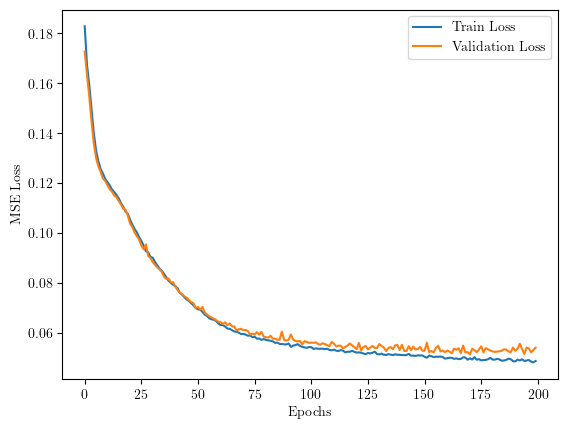

AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.8053 ± 0.0144
F1 Score:  0.8461 ± 0.0132
Precision: 0.8483 ± 0.0156
Recall:    0.8469 ± 0.0101
MCC:       0.7322 ± 0.0192


In [87]:
# Mobile dataset
X = (X_train2, X_val2, X_test2)
y = (y_train2, y_val2, y_test2)

results_file = '../data/mobile_pricing_passive_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline(X, y, hidden_units=12, n_epochs=200, batch_size=16, learning_rate=0.1, momentum=0.9, weight_decay=1e-05)
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline(X, y, hidden_units=12, n_epochs=200, batch_size=16, learning_rate=0.1, momentum=0.9, weight_decay=1e-05, v=False)
        final_performances.append(results)
        
    model, history, results = training_pipeline(X, y, hidden_units=12, n_epochs=200, batch_size=16, learning_rate=0.1, momentum=0.9, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 12,
                'n_epochs': 200,
                'batch_size': 16,
                'learning_rate': 0.1,
                'momentum': 0.9,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
avg_mcc = np.mean([p['mcc'] for p in final_performances])
std_mcc = np.std([p['mcc'] for p in final_performances])

print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")
print(f"MCC:       {avg_mcc:.4f} ± {std_mcc:.4f}")

#### Letter Recognitition Classification 

In [ ]:
# param_grid = {
#     'hidden_units': [24],
#     'n_epochs': [1000, 1500],
#     'batch_size': [16, 32],
#     'learning_rate': [0.5, 0.1, 0.01],
#     'momentum': [0.8, 0.9],
#     'weight_decay': [0.0001, 0.00001]
# }

# best_params3, all_results3 = grid_search_cv(param_grid, X_train3, y_train3, problem='classification')
# print(best_params3)

# # Grid Search: 100%|██████████| 48/48 [1:15:18<00:00, 141.20s/it]
# # {'hidden_units': 24, 'n_epochs': 1000, 'batch_size': 32, 'learning_rate': 0.5, 'momentum': 0.9, 'weight_decay': 1e-05}

Training: 100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s, Train Loss=0.0180, Val Loss=0.0180]



Evaluation on test set:
Accuracy: 75.88%
Precision: 0.7827
Recall: 0.7574
F1 Score: 0.7555
Matthews Correlation Coefficient: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       158
           1       0.55      0.83      0.66       153
           2       0.89      0.84      0.87       147
           3       0.66      0.83      0.73       161
           4       0.81      0.75      0.78       154
           5       0.77      0.74      0.76       155
           6       0.73      0.54      0.62       155
           7       1.00      0.29      0.45       147
           8       0.89      0.74      0.81       151
           9       0.97      0.72      0.83       149
          10       0.61      0.79      0.69       148
          11       0.99      0.78      0.88       152
          12       0.81      0.90      0.85       158
          13       0.93      0.75      0.83       157
          14       0.62      0.8

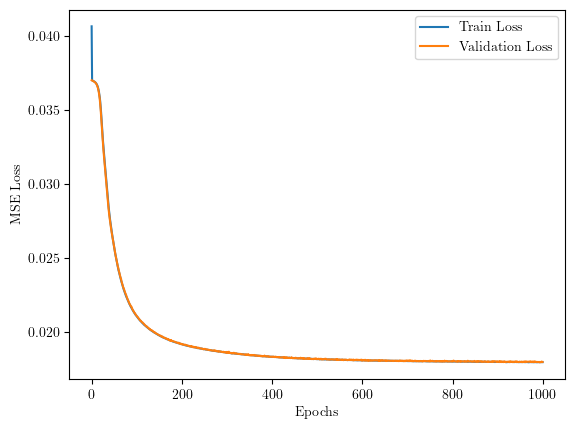

AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.7567 ± 0.0029
F1 Score:  0.7530 ± 0.0034
Precision: 0.7785 ± 0.0038
Recall:    0.7552 ± 0.0029
MCC:       0.7479 ± 0.0030


In [88]:
# Letter recognition
X = (X_train3, X_val3, X_test3)
y = (y_train3, y_val3, y_test3)

results_file = '../data/letter_recognition_passive_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline(X, y, hidden_units=24, n_epochs=1000, batch_size=32, learning_rate=0.5, momentum=0.9, weight_decay=1e-05)
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline(X, y, hidden_units=24, n_epochs=1000, batch_size=32, learning_rate=0.5, momentum=0.9, weight_decay=1e-05, v=False)
        final_performances.append(results)
        
    model, history, results = training_pipeline(X, y, hidden_units=24, n_epochs=1000, batch_size=32, learning_rate=0.5, momentum=0.9, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 24,
                'n_epochs': 1000,
                'batch_size': 32,
                'learning_rate': 0.5,
                'momentum': 0.9,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
avg_mcc = np.mean([p['mcc'] for p in final_performances])
std_mcc = np.std([p['mcc'] for p in final_performances])

print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")
print(f"MCC:       {avg_mcc:.4f} ± {std_mcc:.4f}")

#### Housing Prices Function Approximation

In [48]:
# param_grid = {
#     'hidden_units': [12],
#     'n_epochs': [200, 300, 500],
#     'batch_size': [16, 32],
#     'learning_rate': [0.5, 0.1, 0.01],
#     'momentum': [0.8, 0.9],
#     'weight_decay': [0.0001, 0.00001]
# }

# best_params4, all_results4 = grid_search_cv(param_grid, X_train4, y_train4, problem='regression')
# print(best_params4)

# # Grid Search: 100%|██████████| 72/72 [11:34<00:00,  9.65s/it]
# # {'hidden_units': 12, 'n_epochs': 500, 'batch_size': 16, 'learning_rate': 0.5, 'momentum': 0.8, 'weight_decay': 1e-05}

Training: 100%|██████████| 500/500 [00:04<00:00, 105.35it/s, Train Loss=0.0046, Val Loss=0.0104]



Evaluation on test set:
Test MSE: 0.0063
Test Root MSE: 0.0796
Test MAE: 0.0531
Test R-squared: 0.8251


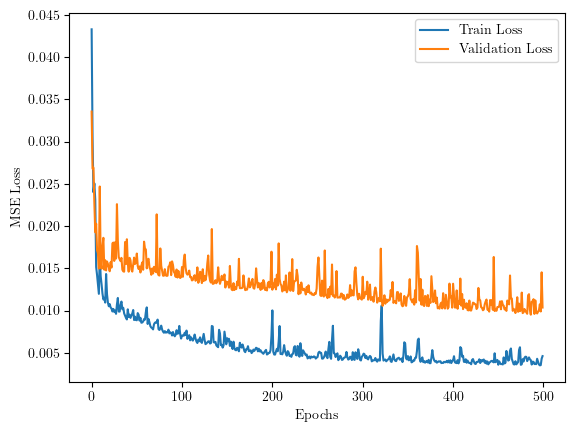

AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS
MSE: 0.0062 ± 0.0004
Root MSE: 0.0789 ± 0.0023
MAE: 0.0515 ± 0.0019
R²: 0.8279 ± 0.0101


In [89]:
# Housing prices
X = (X_train4, X_val4, X_test4)
y = (y_train4, y_val4, y_test4)

results_file = '../data/boston_housing_passive_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline(X, y, problem="regression", hidden_units=12, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline(X, y, problem="regression", hidden_units=12, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05, v=False)
        final_performances.append(results)
        
    model, history, results = training_pipeline(X, y, problem="regression", hidden_units=12, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 12,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.5,
                'momentum': 0.8,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])

print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

#### Concrete Compressive Strength Function Approximation

In [63]:
# param_grid = {
#     'hidden_units': [8],
#     'n_epochs': [200, 500],
#     'batch_size': [16, 32],
#     'learning_rate': [0.5, 0.1, 0.01],
#     'momentum': [0.8, 0.9],
#     'weight_decay': [0.0001, 0.00001]
# }

# best_params5, all_results5 = grid_search_cv(param_grid, X_train5, y_train5, problem='regression')
# print(best_params5)

# # Grid Search: 100%|██████████| 48/48 [17:14<00:00, 21.55s/it]
# # {'hidden_units': 8, 'n_epochs': 500, 'batch_size': 16, 'learning_rate': 0.5, 'momentum': 0.8, 'weight_decay': 1e-05}

Training: 100%|██████████| 500/500 [00:08<00:00, 58.99it/s, Train Loss=0.0055, Val Loss=0.0051]



Evaluation on test set:
Test MSE: 0.0061
Test Root MSE: 0.0779
Test MAE: 0.0613
Test R-squared: 0.8481


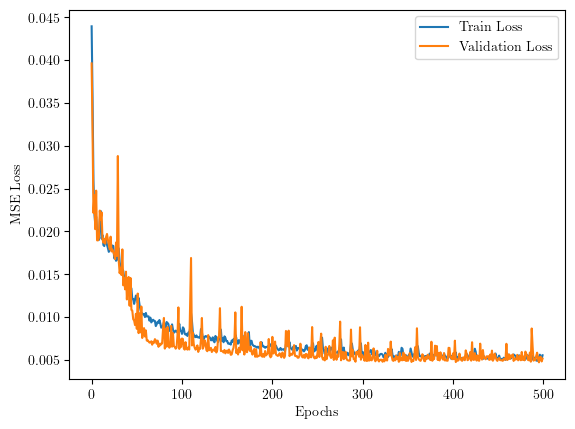

AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS
MSE: 0.0070 ± 0.0023
Root MSE: 0.0828 ± 0.0117
MAE: 0.0641 ± 0.0091
R²: 0.8250 ± 0.0566


In [ ]:
# Concrete dataset
X = (X_train5, X_val5, X_test5)
y = (y_train5, y_val5, y_test5)

results_file = '../data/concrete_strength_passive_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline(X, y, problem="regression", hidden_units=8, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline(X, y, problem="regression", hidden_units=8, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05, v=False)
        final_performances.append(results)
        
    model, history, results = training_pipeline(X, y, problem="regression", hidden_units=8, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 8,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.5,
                'momentum': 0.8,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])

print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

#### Abalone Age Function Approximation

In [ ]:
# param_grid = {
#     'hidden_units': [16],
#     'n_epochs': [200, 500],
#     'batch_size': [16, 32],
#     'learning_rate': [0.5, 0.1, 0.01],
#     'momentum': [0.8, 0.9],
#     'weight_decay': [0.0001, 0.00001]
# }

# best_params6, all_results6 = grid_search_cv(param_grid, X_train6, y_train6, problem='regression')
# print(best_params6)

# # Grid Search: 100%|██████████| 48/48 [1:02:48<00:00, 78.52s/it]
# # {'hidden_units': 16, 'n_epochs': 500, 'batch_size': 16, 'learning_rate': 0.01, 'momentum': 0.9, 'weight_decay': 1e-05}

Training: 100%|██████████| 500/500 [00:30<00:00, 16.25it/s, Train Loss=0.0064, Val Loss=0.0070]



Evaluation on test set:
Test MSE: 0.0065
Test Root MSE: 0.0805
Test MAE: 0.0589
Test R-squared: 0.5310


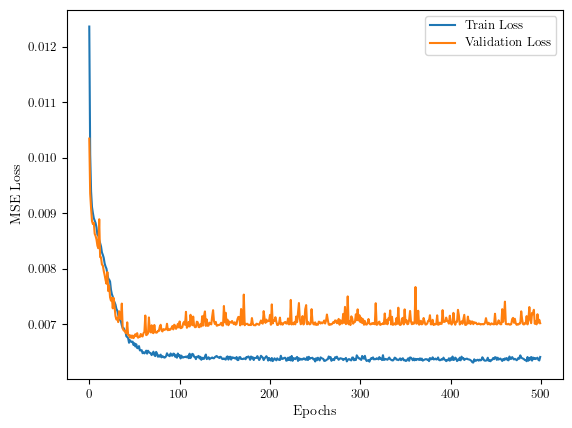

AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS
MSE: 0.0065 ± 0.0001
Root MSE: 0.0808 ± 0.0006
MAE: 0.0589 ± 0.0010
R²: 0.5274 ± 0.0067


In [ ]:
# Abalone dataset
X = (X_train6, X_val6, X_test6)
y = (y_train6, y_val6, y_test6)

results_file = '../data/abalone_age_passive_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline(X, y, problem="regression", hidden_units=16, n_epochs=500, batch_size=16, learning_rate=0.05, momentum=0.9, weight_decay=1e-04)
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline(X, y, problem="regression", hidden_units=16, n_epochs=500, batch_size=16, learning_rate=0.05, momentum=0.9, weight_decay=1e-04, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline(X, y, problem="regression", hidden_units=16, n_epochs=500, batch_size=16, learning_rate=0.05, momentum=0.9, weight_decay=1e-04)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 16,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.05,
                'momentum': 0.9,
                'weight_decay': 0.0001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE PASSIVE PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])

print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

## Active Learning: Uncertainty Sampling

In [108]:
def uncertainty_sampling_classification(model, X_unlabeled, n_samples=1):
    """
    Select most uncertain sample for classification for entropy uncertainty method.
    """
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_unlabeled)
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        
    # Shannon entropy - higher entropy = more uncertainty
    uncertainty = -np.sum(probs * np.log(probs + 1e-10), axis=1)
    # Select most uncertain samples
    uncertain_indices = np.argsort(uncertainty)[-n_samples:]

    return uncertain_indices, uncertainty[uncertain_indices]

In [109]:
def uncertainty_sampling_regression(models, X_unlabeled, n_samples=1):
    """
    Select most uncertain samples for regression using prediction variance.
    """
    predictions = []
    
    # Get predictions from all models in ensemble
    for model in models:
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_unlabeled)
            outputs = model(X_tensor).cpu().numpy().flatten()
            predictions.append(outputs)
    
    # Stack predictions: [n_models, n_samples]
    predictions = np.array(predictions)
    
    # Calculate variance across ensemble predictions for each sample
    uncertainty_scores = np.var(predictions, axis=0)
    
    # Select samples with highest variance (most uncertain)
    uncertain_indices = np.argsort(uncertainty_scores)[-n_samples:]
    
    return uncertain_indices, uncertainty_scores[uncertain_indices]

In [110]:
def train_ensemble_models(X_data, y_data, n_models=5, **model_params):
    """
    Train an ensemble of models with different random seeds for uncertainty estimation.
    """
    models = []
    
    for i in range(n_models):
        # Set different random seed for each model
        torch.manual_seed(42 + i)
        np.random.seed(42 + i)
        
        model, history, results = training_pipeline(
            X_data, y_data, problem="regression", v=False, **model_params
        )
        
        models.append(model)
    
    return models, history, results # return last model's results

In [111]:
def uncertainty_sampling_pipeline(X, y, X_pool, y_pool, problem="classification", budget=100, n_samples=1, **model_params):
    """
    Active learning pipeline for classification.
    """
    results_history = []
    
    # unpack data
    X_train, X_val, X_test = X
    y_train, y_val, y_test = y
    
    # Initial labeled training dataset
    X_train_current = X_train.copy()
    y_train_current = y_train.copy()
    
    # The unlabeled data pool
    X_pool = X_pool.copy()
    y_pool = y_pool.copy()     # Simulated acquired labels with real labels
    
    pbar = tqdm.tqdm(range(budget), desc="Uncertainty Sampling")
    for iteration in pbar:
        # Train model on current labeled data
        X_data = (X_train_current, X_val, X_test)
        y_data = (y_train_current, y_val, y_test)
        
        if problem == "classification":
            model, history, results = training_pipeline(
                X_data, y_data, problem=problem, v=False, **model_params
            )
            # Store results
            results_history.append({
                'iteration': iteration + 1,
                'training_size': len(X_train_current),
                'f1_score': results['f1_score'],
                'accuracy': results['accuracy'],
                'precision': results['precision'],
                'recall': results['recall'],
                'mcc': results['mcc']
            })
            pbar.set_postfix({
                "Train Size": len(X_train_current),
                "Pool Size": len(X_pool),
                "F1": f"{results['f1_score']:.3f}",
                "Acc": f"{results['accuracy']:.3f}"
            })
        else:
            models, history, results = train_ensemble_models(
                X_data, y_data,
                n_models=5, **model_params
            )
            model = models[0]  # Use the first model for evaluation
            results_history.append({
                'iteration': iteration + 1,
                'training_size': len(X_train_current),
                'r2_score': results['r2_score'],
                'mse': results['mse'],
                'root_mse': results['root_mse'],
                'mae': results['mae']
            })
            pbar.set_postfix({
                "Train Size": len(X_train_current),
                "Pool Size": len(X_pool),
                "R2": f"{results['r2_score']:.3f}",
                "MSE": f"{results['mse']:.4f}"
            })
        
        # If not last iteration, select new sample
        if iteration < budget - 1 and len(X_pool) > 0:
            # Select uncertain samples based on problem type
            if problem == "classification":
                uncertain_indices, uncertainty_score = uncertainty_sampling_classification(model, X_pool, n_samples=n_samples)
            else:
                uncertain_indices, uncertainty_score = uncertainty_sampling_regression(models, X_pool, n_samples=n_samples)

            # Move selected samples from pool to training set
            if isinstance(X_pool, np.ndarray):
                new_X = X_pool[uncertain_indices]
                X_pool = np.delete(X_pool, uncertain_indices, axis=0)
            else:
                new_X = X_pool.iloc[uncertain_indices].values
                X_pool = X_pool.drop(X_pool.index[uncertain_indices]).reset_index(drop=True)

            # Obtain the label
            if isinstance(y_pool, np.ndarray):
                new_y = y_pool[uncertain_indices]
                y_pool = np.delete(y_pool, uncertain_indices, axis=0)
            else:
                new_y = y_pool.iloc[uncertain_indices].values
                y_pool = y_pool.drop(y_pool.index[uncertain_indices]).reset_index(drop=True)

            # Add to training set - handle both numpy arrays and pandas objects
            if isinstance(X_train_current, np.ndarray):
                X_train_current = np.vstack([X_train_current, new_X])
            else:
                X_train_current = pd.concat([X_train_current, pd.DataFrame(new_X)], ignore_index=True)
                
            if isinstance(y_train_current, np.ndarray):
                y_train_current = np.vstack([y_train_current, new_y])
            else:
                y_train_current = pd.concat([y_train_current, pd.Series(new_y)], ignore_index=True)
    
    plot_history(history) # plot history of final model
    
    return results_history, model

In [112]:
def uncertainty_sampling(X, y, problem='classification', budget=100, n_samples=1, **model_params):
    """
    Uncertainty sampling active learning for classification and regression.
    """
    
    # Data processing
    X_train, X_val, X_test = X
    y_train, y_val, y_test = y
        
    # randomly sample n_samples from the pool to form the initial training set
    initial_indices = np.random.choice(len(X_train), size=n_samples, replace=False)
    X_train_initial = X_train[initial_indices]
    y_train_initial = y_train[initial_indices]
    # Remove initial samples from the pool
    X_pool = np.delete(X_train, initial_indices, axis=0)
    y_pool = np.delete(y_train, initial_indices, axis=0)
        
    X_data = (X_train_initial, X_val, X_test)
    y_data = (y_train_initial, y_val, y_test)
    
    results_history, model = uncertainty_sampling_pipeline(
        X_data, y_data, X_pool, y_pool, problem=problem, budget=budget, n_samples=n_samples, **model_params
    )
  
    return results_history, model
    

In [121]:
def plot_active_learning_results(all_results, problem='classification', saveas=None):
    # Prepare data for visualization
    training_sizes = [r['training_size'] for r in all_results[0]]

    if problem == 'classification':
        f1_by_size = {size: [] for size in training_sizes}

        for run_results in all_results:
            for result in run_results:
                size = result['training_size']
                f1_by_size[size].append(result['f1_score'])

        # Prepare data for plotting
        sizes = sorted(f1_by_size.keys())
        f1_means = [np.mean(f1_by_size[size]) for size in sizes]
        f1_se = [np.std(f1_by_size[size]) / np.sqrt(len(f1_by_size[size])) for size in sizes]

        # Create the plot with error bars
        fig, ax = plt.subplots(figsize=(column_width_inches, column_width_inches * 0.75))

        # F1 Score plot with error bars
        ax.errorbar(sizes, f1_means, yerr=f1_se, fmt='o-', color='darkblue', 
                    linewidth=2, markersize=4, capsize=3, capthick=1)
        ax.set_xlabel('Training Set Size', fontsize=16)
        ax.set_ylabel('F1 Score', fontsize=16)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=10)

    else:  # regression
        r2_by_size = {size: [] for size in training_sizes}

        for run_results in all_results:
            for result in run_results:
                size = result['training_size']
                r2_by_size[size].append(result['r2_score'])

        # Prepare data for plotting
        sizes = sorted(r2_by_size.keys())
        r2_means = [np.mean(r2_by_size[size]) for size in sizes]
        r2_se = [np.std(r2_by_size[size]) / np.sqrt(len(r2_by_size[size])) for size in sizes]

        # Create the plot with error bars
        fig, ax = plt.subplots(figsize=(column_width_inches, column_width_inches * 0.75))

        # R2 Score plot with error bars
        ax.errorbar(sizes, r2_means, yerr=r2_se, fmt='o-', color='red', 
                    linewidth=2, markersize=4, capsize=3, capthick=1)

        ax.set_xlabel('Training Set Size', fontsize=16)
        ax.set_ylabel('R-squared Score', fontsize=16)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    
    if saveas is not None:
        plt.savefig(f'../report/plots/{saveas}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

#### Breast Cancer Classification

In [122]:
print(f"The original training set size for breast cancer classification is {X_train1.shape[0]} samples.")

The original training set size for breast cancer classification is 398 samples.


AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.9833 ± 0.0026
F1 Score:  0.9768 ± 0.0037
Precision: 1.0000 ± 0.0000
Recall:    0.9548 ± 0.0071


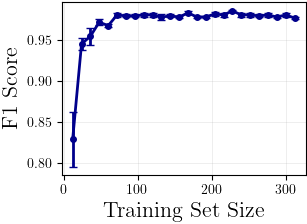

In [123]:
max_samples = (int)(0.8 * len(X_train1))  # consider at most 80% of original training data
n_samples = max_samples // 25  # number of samples to acquire in each iteration
budget = max_samples // n_samples  # number of iterations

# Define the results file path
results_file = '../data/breast_cancer_uncertainty_results.pkl'

# Check if results already exist
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    
    all_results = saved_data['all_results']
    final_performances = saved_data['final_performances']
else:
    all_results = []
    final_performances = []
    
    # Perform ten independent runs
    for i in range(10):
        np.random.seed(42 + i)
        torch.manual_seed(42 + i)
        # Breast Cancer Active Learning
        active_results, final_model = uncertainty_sampling(
            (X_train1, X_val1, X_test1),
            (y_train1, y_val1, y_test1),
            problem="classification",
            budget=budget,
            n_samples=n_samples,
            hidden_units=16,
            n_epochs=500,
            batch_size=32,
            learning_rate=0.1,
            momentum=0.8,
            weight_decay=0.0001,
        )
        all_results.append(active_results)
        
        # Store final performance for this run
        final_result = active_results[-1]
        final_performances.append({
            'accuracy': final_result['accuracy'],
            'f1_score': final_result['f1_score'],
            'precision': final_result['precision'],
            'recall': final_result['recall'],
            'training_size': final_result['training_size']
        })
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'all_results': all_results,
            'final_performances': final_performances,
            'experiment_config': {
                'max_samples': max_samples,
                'n_samples': n_samples,
                'budget': budget,
                'hidden_units': 16,
                'n_epochs': 500,
                'batch_size': 32,
                'learning_rate': 0.1,
                'momentum': 0.8,
                'weight_decay': 0.0001
            }
        }, f)

# Calculate and print average final performance measures
print("="*60)
print("AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")

plot_active_learning_results(all_results, problem='classification', saveas='breast_cancer_uncertainty_sampling')

#### Mobile Classification

AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.8012 ± 0.0093
F1 Score:  0.8408 ± 0.0113
Precision: 0.8502 ± 0.0077
Recall:    0.8444 ± 0.0075


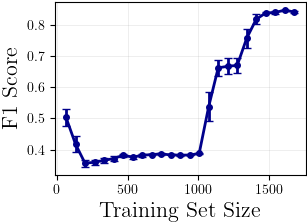

In [124]:
max_samples = (int)(0.8 * len(X_train2))  # consider at most 80% of original training data
n_samples = max_samples // 25  # number of samples to acquire in each iteration
budget = max_samples // n_samples  # number of iterations

# Define the results file path
results_file = '../data/mobile_pricing_uncertainty_results.pkl'

# Check if results already exist
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    
    all_results = saved_data['all_results']
    final_performances = saved_data['final_performances']
else:
    all_results = []
    final_performances = []
    
    # Perform ten independent runs
    for i in range(10):
        np.random.seed(42 + i)
        torch.manual_seed(42 + i)
        # Mobile Classification Active Learning
        active_results, final_model = uncertainty_sampling(
            (X_train2, X_val2, X_test2),
            (y_train2, y_val2, y_test2),
            problem="classification",
            budget=budget,
            n_samples=n_samples,
            hidden_units=12,
            n_epochs=200,
            batch_size=16,
            learning_rate=0.1,
            momentum=0.9,
            weight_decay=1e-05,
        )
        all_results.append(active_results)
        
        # Store final performance for this run
        final_result = active_results[-1]
        final_performances.append({
            'accuracy': final_result['accuracy'],
            'f1_score': final_result['f1_score'],
            'precision': final_result['precision'],
            'recall': final_result['recall'],
            'training_size': final_result['training_size']
        })
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'all_results': all_results,
            'final_performances': final_performances,
            'experiment_config': {
                'max_samples': max_samples,
                'n_samples': n_samples,
                'budget': budget,
                'hidden_units': 12,
                'n_epochs': 200,
                'batch_size': 16,
                'learning_rate': 0.1,
                'momentum': 0.9,
                'weight_decay': 1e-05
            }
        }, f)

# Calculate and print average final performance measures
print("="*60)
print("AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")

plot_active_learning_results(all_results, problem='classification', saveas='mobile_pricing_uncertainty_sampling')

#### Letter Recognition Classification

In [125]:
X_train3.shape

(14000, 16)

AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.7636 ± 0.0023
F1 Score:  0.7614 ± 0.0027
Precision: 0.7822 ± 0.0039
Recall:    0.7623 ± 0.0023


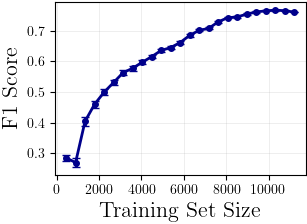

In [126]:
max_samples = (int)(0.8 * len(X_train3))
n_samples = max_samples // 25
budget = max_samples // n_samples 

# Define the results file path
results_file = '../data/letter_recognition_uncertainty_results.pkl'

# Check if results already exist
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    
    all_results = saved_data['all_results']
    final_performances = saved_data['final_performances']
else:
    all_results = []
    final_performances = []
    
    # Perform ten independent runs
    for i in range(10):
        np.random.seed(42 + i)
        torch.manual_seed(42 + i)
        # Letter Recognition Active Learning
        active_results, final_model = uncertainty_sampling(
            (X_train3, X_val3, X_test3),
            (y_train3, y_val3, y_test3),
            problem="classification",
            budget=budget,
            n_samples=n_samples,
            hidden_units=24,
            n_epochs=1000,
            batch_size=32,
            learning_rate=0.5,
            momentum=0.9,
            weight_decay=1e-05,
        )
        all_results.append(active_results)
        
        # Store final performance for this run
        final_result = active_results[-1]
        final_performances.append({
            'accuracy': final_result['accuracy'],
            'f1_score': final_result['f1_score'],
            'precision': final_result['precision'],
            'recall': final_result['recall'],
            'training_size': final_result['training_size']
        })
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'all_results': all_results,
            'final_performances': final_performances,
            'experiment_config': {
                'max_samples': max_samples,
                'n_samples': n_samples,
                'budget': budget,
                'hidden_units': 24,
                'n_epochs': 1000,
                'batch_size': 32,
                'learning_rate': 0.5,
                'momentum': 0.9,
                'weight_decay': 1e-05
            }
        }, f)

# Calculate and print average final performance measures
print("="*60)
print("AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")

plot_active_learning_results(all_results, problem='classification', saveas='letter_recognition_uncertainty_sampling')

#### Boston Housing Function Approximation

In [85]:
X_train4.shape

(353, 13)

AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS
MSE: 0.0066 ± 0.0003
Root MSE: 0.0813 ± 0.0019
MAE: 0.0548 ± 0.0011
R²: 0.8176 ± 0.0089


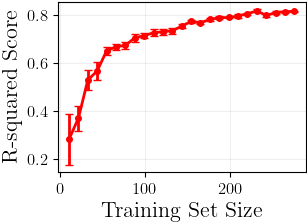

In [86]:
max_samples = (int)(0.8 * len(X_train4))
n_samples = max_samples // 25
budget = max_samples // n_samples

# Define the results file path
results_file = '../data/boston_housing_uncertainty_results.pkl'

# Check if results already exist
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    
    all_results = saved_data['all_results']
    final_performances = saved_data['final_performances']
else:
    all_results = []
    final_performances = []
    
    # Perform ten independent runs
    for i in range(10):
        np.random.seed(42 + i)
        torch.manual_seed(42 + i)
        # Boston housing
        active_results, final_model = uncertainty_sampling(
            (X_train4, X_val4, X_test4),
            (y_train4, y_val4, y_test4),
            problem="regression",
            budget=budget,
            n_samples=n_samples,
            hidden_units=12,
            n_epochs=500,
            batch_size=16,
            learning_rate=0.5,
            momentum=0.8,
            weight_decay=1e-05,
        )
        all_results.append(active_results)
        
        # Store final performance for this run
        final_result = active_results[-1]
        final_performances.append({
            'mse': final_result['mse'],
            'root_mse': final_result['root_mse'],
            'mae': final_result['mae'],
            'r2_score': final_result['r2_score'],
            'training_size': final_result['training_size']
        })
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'all_results': all_results,
            'final_performances': final_performances,
            'experiment_config': {
                'max_samples': max_samples,
                'n_samples': n_samples,
                'budget': budget,
                'hidden_units': 12,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.5,
                'momentum': 0.8,
                'weight_decay': 1e-05
            }
        }, f)

# Calculate and print average final performance measures
print("="*60)
print("AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])
print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

plot_active_learning_results(all_results, problem='regression', saveas='boston_housing_uncertainty_sampling')

#### Concrete Compressive Strength Function Approximation

In [87]:
X_train5.shape

(721, 8)

AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS
MSE: 0.0062 ± 0.0005
Root MSE: 0.0784 ± 0.0029
MAE: 0.0612 ± 0.0030
R²: 0.8461 ± 0.0117


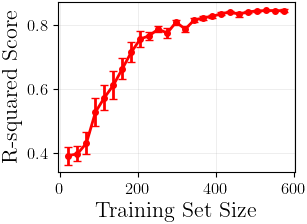

In [88]:
max_samples = (int)(0.8 * len(X_train5))
n_samples = max_samples // 25
budget = max_samples // n_samples

# Define the results file path
results_file = '../data/concrete_strength_uncertainty_results.pkl'

# Check if results already exist
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    
    all_results = saved_data['all_results']
    final_performances = saved_data['final_performances']
else:
    all_results = []
    final_performances = []
    
    # Perform ten independent runs
    for i in range(10):
        np.random.seed(42 + i)
        torch.manual_seed(42 + i)
        # Concrete Strength Active Learning
        active_results, final_model = uncertainty_sampling(
            (X_train5, X_val5, X_test5),
            (y_train5, y_val5, y_test5),
            problem="regression",
            budget=budget,
            n_samples=n_samples,
            hidden_units=8,
            n_epochs=500,
            batch_size=16,
            learning_rate=0.5,
            momentum=0.8,
            weight_decay=1e-05,
        )
        all_results.append(active_results)
        
        # Store final performance for this run
        final_result = active_results[-1]
        final_performances.append({
            'mse': final_result['mse'],
            'root_mse': final_result['root_mse'],
            'mae': final_result['mae'],
            'r2_score': final_result['r2_score'],
            'training_size': final_result['training_size']
        })
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'all_results': all_results,
            'final_performances': final_performances,
            'experiment_config': {
                'max_samples': max_samples,
                'n_samples': n_samples,
                'budget': budget,
                'hidden_units': 8,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.5,
                'momentum': 0.8,
                'weight_decay': 1e-05
            }
        }, f)

# Calculate and print average final performance measures
print("="*60)
print("AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])
print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

plot_active_learning_results(all_results, problem='regression', saveas='concrete_strength_uncertainty_sampling')

#### Abalone Age Function Approximation

In [89]:
X_train6.shape

(2923, 9)

AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS
MSE: 0.0071 ± 0.0004
Root MSE: 0.0841 ± 0.0024
MAE: 0.0642 ± 0.0043
R²: 0.4869 ± 0.0292


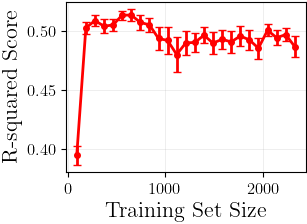

In [90]:
max_samples = (int)(0.8 * len(X_train6))
n_samples = max_samples // 25
budget = max_samples // n_samples

# Define the results file path
results_file = '../data/abalone_age_uncertainty_results.pkl'

# Check if results already exist
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    
    all_results = saved_data['all_results']
    final_performances = saved_data['final_performances']
else:
    all_results = []
    final_performances = []
    
    # Perform ten independent runs
    for i in range(10):
        np.random.seed(42 + i)
        torch.manual_seed(42 + i)
        # Abalone Age Active Learning
        active_results, final_model = uncertainty_sampling(
            (X_train6, X_val6, X_test6),
            (y_train6, y_val6, y_test6),
            problem="regression",
            budget=budget,
            n_samples=n_samples,
            hidden_units=16,
            n_epochs=500,
            batch_size=16,
            learning_rate=0.05,
            momentum=0.9,
            weight_decay=1e-04,
        )
        all_results.append(active_results)
        
        # Store final performance for this run
        final_result = active_results[-1]
        final_performances.append({
            'mse': final_result['mse'],
            'root_mse': final_result['root_mse'],
            'mae': final_result['mae'],
            'r2_score': final_result['r2_score'],
            'training_size': final_result['training_size']
        })
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'all_results': all_results,
            'final_performances': final_performances,
            'experiment_config': {
                'max_samples': max_samples,
                'n_samples': n_samples,
                'budget': budget,
                'hidden_units': 16,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.05,
                'momentum': 0.9,
                'weight_decay': 1e-04
            }
        }, f)

# Calculate and print average final performance measures
print("="*60)
print("AVERAGE FINAL PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])
print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

plot_active_learning_results(all_results, problem='regression', saveas='abalone_age_uncertainty_sampling')

## Active Learning: Sensitivity Analysis

In [34]:
beta = 0.9

In [35]:
def select_informative_patterns(model, X_candidate, y_candidate, beta=0.9):
    """
    Vectorized implementation of SASLA pattern selection for improved performance.
    """
    # Extract weights and biases
    params = list(model.parameters())
    if len(params) < 4:
        return X_candidate, y_candidate, {}
    
    v_weights = params[0]
    v_bias = params[1]
    w_weights = params[2]
    w_bias = params[3]
    
    with torch.no_grad():
        hidden_pre = torch.matmul(X_candidate, v_weights.T) + v_bias  # [n_patterns, hidden_size]
        hidden_post = torch.sigmoid(hidden_pre)  # y_j in paper
        
        output_pre = torch.matmul(hidden_post, w_weights.T) + w_bias  # [n_patterns, output_size]
        output_probs = torch.sigmoid(output_pre)  # o_k in paper
        
        # Compute v_ji * x_i for all patterns and hidden units
        # v_weights: [hidden_size, input_size], X_candidate: [n_patterns, input_size]
        v_ji_xi = torch.matmul(X_candidate, v_weights.T)  # [n_patterns, hidden_size]
        
        # hidden_post: [n_patterns, 1, hidden_size]
        # w_weights: [1, output_size, hidden_size]
        # v_ji_xi: [n_patterns, 1, hidden_size]
        hidden_expanded = hidden_post.unsqueeze(1)  # [n_patterns, 1, hidden_size]
        w_weights_expanded = w_weights.unsqueeze(0)  # [1, output_size, hidden_size]
        v_ji_xi_expanded = v_ji_xi.unsqueeze(1)  # [n_patterns, 1, hidden_size]
        
        # computation of w_kj * (1 - y_j) * v_ji * x_i
        # Sum over hidden units j for each pattern and output class
        sensitivity_sum = torch.sum(
            w_weights_expanded * (1 - hidden_expanded) * v_ji_xi_expanded, 
            dim=2
        )  # [n_patterns, output_size]
        
        # Apply output derivative: (1-o_k)*o_k
        output_derivative = output_probs * (1 - output_probs)  # [n_patterns, output_size]
        
        # Complete sensitivity computation
        class_sensitivities = torch.abs(output_derivative * sensitivity_sum)  # [n_patterns, output_size]
        
        # Pattern informativeness: sum across all output classes
        informativeness_scores = torch.sum(class_sensitivities, dim=1)  # [n_patterns]
        
        # Convert to numpy for threshold computation
        informativeness_np = informativeness_scores.cpu().numpy()
    
    # Calculate selection threshold
    avg_informativeness = np.mean(informativeness_np)
    selection_threshold = (1 - beta) * avg_informativeness
    
    # Select patterns above threshold
    selected_mask = informativeness_np > selection_threshold
    
    # Ensure at least one pattern is selected
    if not np.any(selected_mask):
        most_informative_idx = np.argmax(informativeness_np)
        selected_mask[most_informative_idx] = True
    
    selected_X = X_candidate[selected_mask]
    selected_y = y_candidate[selected_mask]
    
    selection_stats = {
        'n_selected': selected_mask.sum(),
        'n_total': len(X_candidate),
        'selection_ratio': selected_mask.sum() / len(X_candidate),
        'avg_informativeness': avg_informativeness,
        'threshold': selection_threshold,
        'selected_informativeness': informativeness_np[selected_mask].mean() if np.any(selected_mask) else 0.0,
        'min_informativeness': informativeness_np.min(),
        'max_informativeness': informativeness_np.max()
    }

    return selected_X, selected_y, selection_stats

In [36]:
def train_model_sasla(model, X_train, y_train, X_val, y_val, criterion=None, optimizer=None, 
                     n_epochs=100, batch_size=32, beta=0.9, mse_threshold=1e-4, v=True):
    """
    Train neural network using SASLA - modified to select new subset after each epoch
    """
    if criterion is None:
        criterion = nn.MSELoss()
    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    # Step 1: Initialize
    DC = X_train.clone()  # Candidate set DC
    DC_labels = y_train.clone()
    
    # Initial subset DS0 = DC
    DS_current = DC.clone()
    DS_current_labels = DC_labels.clone()
    
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'selection_stats': [],
        'subset_sizes': [],
        'train_accuracy': [],
        'subset_intervals': []
    }
    
    total_epochs = 0
    converged = False
    
    # Step 2: Repeat until convergence
    while not converged and total_epochs < n_epochs:
        if v:
            print(f"\n--- Epoch {total_epochs + 1} ---")
            print(f"Training subset size: {len(DS_current)}")
        
        model.train()
        
        permutation = torch.randperm(DS_current.size()[0])
        epoch_loss = 0.0
        num_batches = (DS_current.size()[0] + batch_size - 1) // batch_size
        
        for i in range(0, DS_current.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = DS_current[indices], DS_current_labels[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / num_batches
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        
        # Store metrics
        history['train_loss'].append(avg_epoch_loss)
        history['val_loss'].append(val_loss)
        history['subset_sizes'].append(len(DS_current))
        
        if v:
            status = f"Epoch {total_epochs+1}: "
            status += f"Loss={avg_epoch_loss:.4f}, Val Loss={val_loss:.4f}"
            print(status)
        
        # Check termination criteria
        if avg_epoch_loss < mse_threshold:
            if v:
                print(f"Termination: MSE {avg_epoch_loss:.6f} below threshold {mse_threshold}")
            converged = True
        
        total_epochs += 1
        
        # Select new subset after each epoch
        if not converged and total_epochs < n_epochs:
            
            with torch.no_grad():
                # Step 2b: Compute new training subset DSs
                DS_new, DS_new_labels, stats = select_informative_patterns(
                    model, DC, DC_labels, beta=beta
                )
                
                # Store selection statistics
                stats['epoch'] = total_epochs
                history['selection_stats'].append(stats)
                history['subset_intervals'].append(total_epochs)
                
                if v:
                    print(f"Selected {stats['n_selected']} out of {stats['n_total']} patterns")
                    print(f"Average informativeness: {stats['avg_informativeness']:.6f}")
                
                # Update current training subset: DT = DSs
                DS_current = DS_new
                DS_current_labels = DS_new_labels
    
    if v:
        print(f"\nSASLA training completed after {total_epochs} epochs")
        print(f"Final subset size: {len(DS_current)}")
        print(f"Final training loss: {history['train_loss'][-1]:.6f}")
        print(f"Final validation loss: {history['val_loss'][-1]:.6f}")
        
        # Convergence reason
        if total_epochs >= n_epochs:
            print("Termination reason: Maximum epochs reached")
        elif history['train_loss'][-1] < mse_threshold:
            print("Termination reason: MSE threshold achieved")
    
    return model, history

In [50]:
def plot_sasla_history(history):
    """
    Plot SASLA-specific training metrics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    
    # Training and validation loss
    axes[0].plot(history['train_loss'], label='Train Loss', alpha=0.7)
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress')
    axes[0].legend()
    axes[0].grid(True)

    # Subset sizes over iterations
    if history['subset_sizes']:
        axes[1].plot(history['subset_sizes'], 'o-')
        axes[1].set_xlabel('Subset Iteration')
        axes[1].set_ylabel('Selected Patterns')
        axes[1].set_title('Pattern Selection Over Time')
        axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [57]:
def create_sasla_selection_plot(history, saveas=None):
    fig, ax = plt.subplots(figsize=(column_width_inches, column_width_inches * 0.75))
    
    ax.plot(history['subset_sizes'], 'o-')
    ax.set_xlabel('Subset Iteration', fontsize=16)
    ax.set_ylabel('Selected Patterns', fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.tight_layout()
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}.pdf")
    
    plt.show()

In [58]:
def training_pipeline_sasla(X, y, problem='classification', hidden_units=10, n_epochs=100, batch_size=32,
                           learning_rate=0.001, momentum=0.9, weight_decay=1e-5, 
                           beta=0.9, v=True):
    """
    SASLA training pipeline for classification and regression tasks.
    """
    # unzip data
    X_train, X_val, X_test = X
    y_train, y_val, y_test = y
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    if problem == "classification":
        y_train_tensor = torch.FloatTensor(y_train)
        y_val_tensor = torch.FloatTensor(y_val)
        n_output = y_train.shape[1]
    else:
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
        n_output = 1
  
    n_input = X_train.shape[1]
    n_hidden = hidden_units

    model = NeuralNetwork(n_input, n_hidden, n_output)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
    # Train using SASLA
    trained_model, history = train_model_sasla(
        model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
        criterion=criterion, optimizer=optimizer,
        n_epochs=n_epochs, batch_size=batch_size, beta=beta, v=v
    )
    
    # Evaluate on test set
    results = evaluate_model(trained_model, X_test, y_test, problem=problem, v=v)
    
    if v:
        # Plot training curves
        plot_sasla_history(history)
    
    return trained_model, history, results

#### Breast Cancer Classification


--- Epoch 1 ---
Training subset size: 398
Epoch 1: Loss=0.2465, Val Loss=0.2277
Selected 397 out of 398 patterns
Average informativeness: 0.061703

--- Epoch 2 ---
Training subset size: 397
Epoch 2: Loss=0.2246, Val Loss=0.2219
Selected 398 out of 398 patterns
Average informativeness: 0.111844

--- Epoch 3 ---
Training subset size: 398
Epoch 3: Loss=0.2237, Val Loss=0.2156
Selected 395 out of 398 patterns
Average informativeness: 0.163649

--- Epoch 4 ---
Training subset size: 395
Epoch 4: Loss=0.2142, Val Loss=0.2082
Selected 391 out of 398 patterns
Average informativeness: 0.227148

--- Epoch 5 ---
Training subset size: 391
Epoch 5: Loss=0.2015, Val Loss=0.2001
Selected 384 out of 398 patterns
Average informativeness: 0.289365

--- Epoch 6 ---
Training subset size: 384
Epoch 6: Loss=0.1942, Val Loss=0.1914
Selected 383 out of 398 patterns
Average informativeness: 0.356075

--- Epoch 7 ---
Training subset size: 383
Epoch 7: Loss=0.1854, Val Loss=0.1812
Selected 382 out of 398 pattern

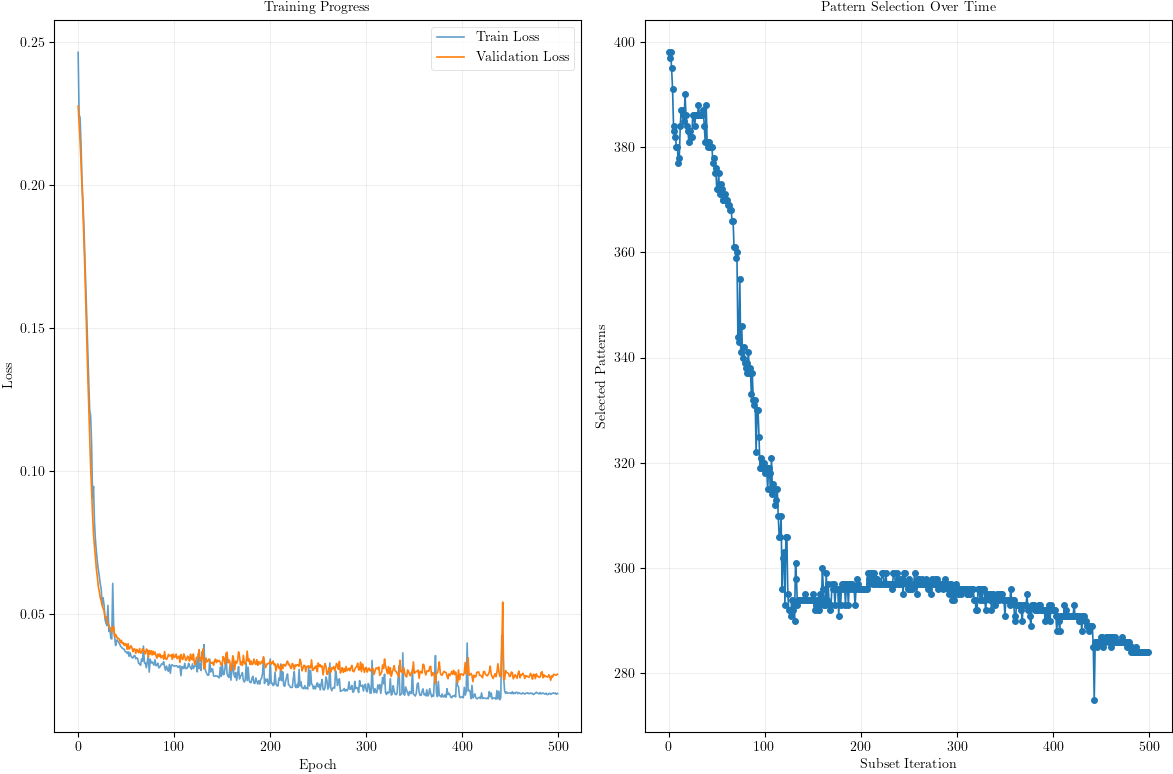

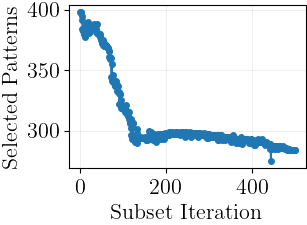

AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.9868 ± 0.0044
F1 Score:  0.9818 ± 0.0062
Precision: 1.0000 ± 0.0000
Recall:    0.9643 ± 0.0119
MCC:       0.9719 ± 0.0093


In [59]:
# Breast cancer
X = (X_train1, X_val1, X_test1)
y = (y_train1, y_val1, y_test1)

results_file = '../data/breast_cancer_sasla_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline_sasla(X, y, hidden_units=16, n_epochs=500, batch_size=32, learning_rate=0.1, momentum=0.8, weight_decay=0.0001, v=True)
    create_sasla_selection_plot(history, saveas='breast_cancer_sasla_selection')
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline_sasla(X, y, hidden_units=16, n_epochs=500, batch_size=32, learning_rate=0.1, momentum=0.8, weight_decay=0.0001, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline_sasla(X, y, hidden_units=16, n_epochs=500, batch_size=32, learning_rate=0.1, momentum=0.8, weight_decay=0.0001, v=True)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 16,
                'n_epochs': 500,
                'batch_size': 32,
                'learning_rate': 0.1,
                'momentum': 0.8,
                'weight_decay': 0.0001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
avg_mcc = np.mean([p['mcc'] for p in final_performances])
std_mcc = np.std([p['mcc'] for p in final_performances])

print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")
print(f"MCC:       {avg_mcc:.4f} ± {std_mcc:.4f}")

#### Mobile Price Classification


--- Epoch 1 ---
Training subset size: 2100
Epoch 1: Loss=0.1889, Val Loss=0.1758
Selected 2099 out of 2100 patterns
Average informativeness: 0.248720

--- Epoch 2 ---
Training subset size: 2099
Epoch 2: Loss=0.1709, Val Loss=0.1665
Selected 2100 out of 2100 patterns
Average informativeness: 0.861027

--- Epoch 3 ---
Training subset size: 2100
Epoch 3: Loss=0.1626, Val Loss=0.1592
Selected 2099 out of 2100 patterns
Average informativeness: 1.156130

--- Epoch 4 ---
Training subset size: 2099
Epoch 4: Loss=0.1541, Val Loss=0.1493
Selected 2100 out of 2100 patterns
Average informativeness: 1.340603

--- Epoch 5 ---
Training subset size: 2100
Epoch 5: Loss=0.1443, Val Loss=0.1396
Selected 2100 out of 2100 patterns
Average informativeness: 1.560796

--- Epoch 6 ---
Training subset size: 2100
Epoch 6: Loss=0.1367, Val Loss=0.1326
Selected 2100 out of 2100 patterns
Average informativeness: 1.781417

--- Epoch 7 ---
Training subset size: 2100
Epoch 7: Loss=0.1305, Val Loss=0.1283
Selected 210

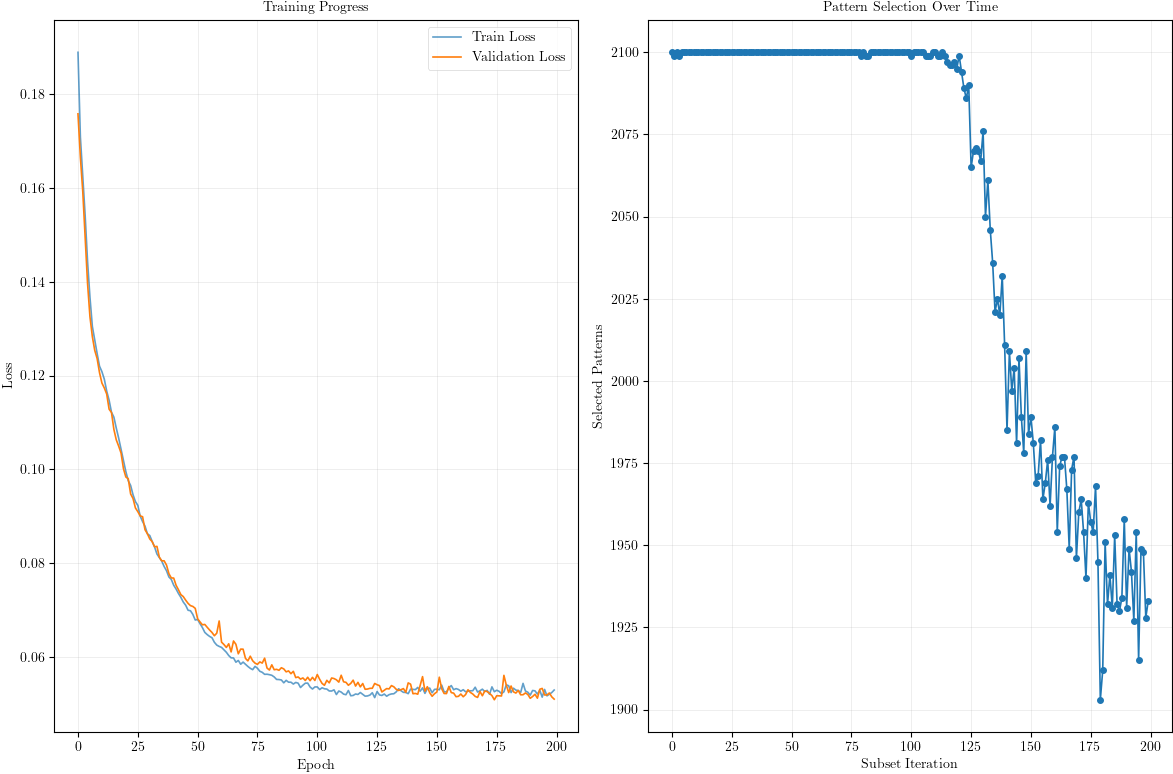

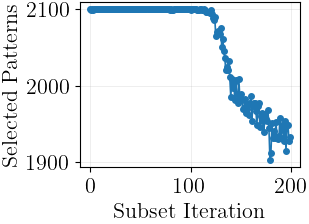

AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.8055 ± 0.0103
F1 Score:  0.8457 ± 0.0095
Precision: 0.8531 ± 0.0103
Recall:    0.8484 ± 0.0074
MCC:       0.7367 ± 0.0137


In [60]:
# Mobile dataset
X = (X_train2, X_val2, X_test2)
y = (y_train2, y_val2, y_test2)

results_file = '../data/mobile_pricing_sasla_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline_sasla(X, y, hidden_units=12, n_epochs=200, batch_size=16, learning_rate=0.1, momentum=0.9, weight_decay=1e-05)
    create_sasla_selection_plot(history, saveas='mobile_pricing_sasla_selection')
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline_sasla(X, y, hidden_units=12, n_epochs=200, batch_size=16, learning_rate=0.1, momentum=0.9, weight_decay=1e-05, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline_sasla(X, y, hidden_units=12, n_epochs=200, batch_size=16, learning_rate=0.1, momentum=0.9, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 12,
                'n_epochs': 200,
                'batch_size': 16,
                'learning_rate': 0.1,
                'momentum': 0.9,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
avg_mcc = np.mean([p['mcc'] for p in final_performances])
std_mcc = np.std([p['mcc'] for p in final_performances])

print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")
print(f"MCC:       {avg_mcc:.4f} ± {std_mcc:.4f}")

#### Letter Recognition Classification


--- Epoch 1 ---
Training subset size: 14000
Epoch 1: Loss=0.0410, Val Loss=0.0370
Selected 14000 out of 14000 patterns
Average informativeness: 0.158616

--- Epoch 2 ---
Training subset size: 14000
Epoch 2: Loss=0.0370, Val Loss=0.0370
Selected 14000 out of 14000 patterns
Average informativeness: 0.159865

--- Epoch 3 ---
Training subset size: 14000
Epoch 3: Loss=0.0370, Val Loss=0.0369
Selected 14000 out of 14000 patterns
Average informativeness: 0.160469

--- Epoch 4 ---
Training subset size: 14000
Epoch 4: Loss=0.0369, Val Loss=0.0369
Selected 14000 out of 14000 patterns
Average informativeness: 0.160188

--- Epoch 5 ---
Training subset size: 14000
Epoch 5: Loss=0.0369, Val Loss=0.0369
Selected 14000 out of 14000 patterns
Average informativeness: 0.159729

--- Epoch 6 ---
Training subset size: 14000
Epoch 6: Loss=0.0369, Val Loss=0.0369
Selected 14000 out of 14000 patterns
Average informativeness: 0.157491

--- Epoch 7 ---
Training subset size: 14000
Epoch 7: Loss=0.0369, Val Loss=

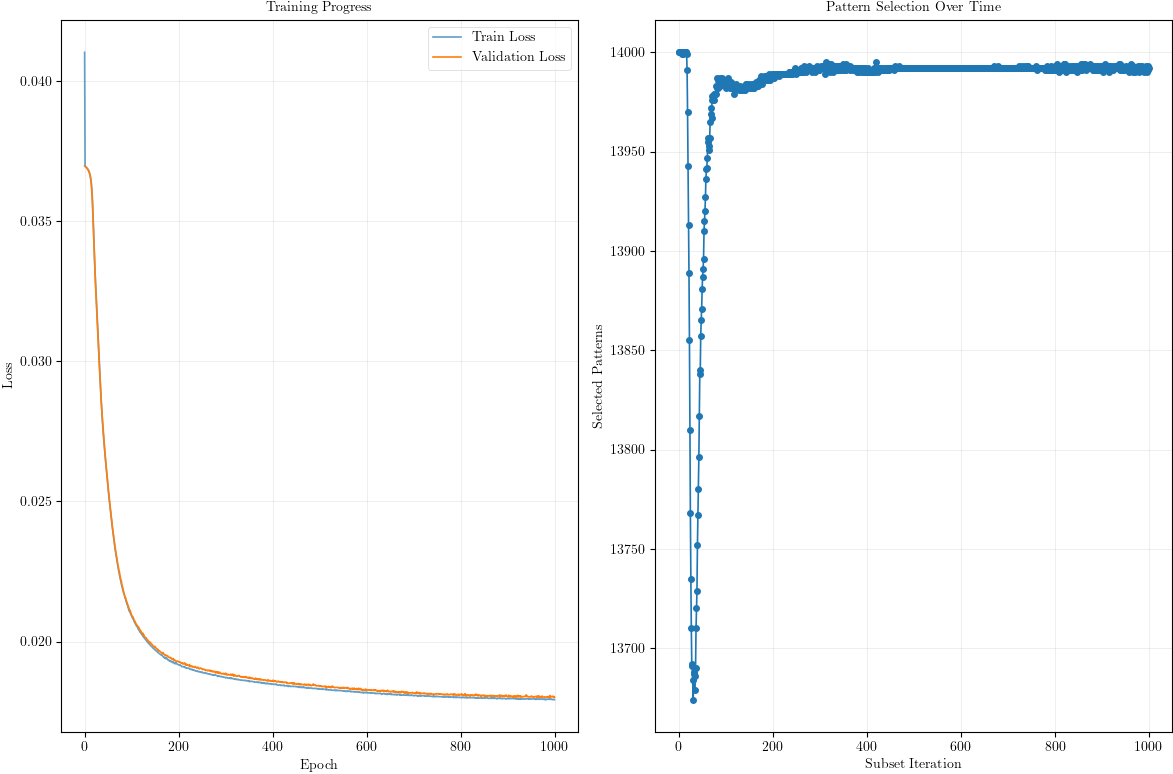

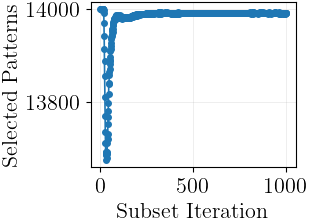

AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS
Accuracy:  0.7560 ± 0.0032
F1 Score:  0.7524 ± 0.0032
Precision: 0.7784 ± 0.0027
Recall:    0.7545 ± 0.0032
MCC:       0.7471 ± 0.0033


In [61]:
# Letter recognition
X = (X_train3, X_val3, X_test3)
y = (y_train3, y_val3, y_test3)

results_file = '../data/letter_recognition_sasla_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline_sasla(X, y, hidden_units=24, n_epochs=1000, batch_size=32, learning_rate=0.5, momentum=0.9, weight_decay=1e-05)
    create_sasla_selection_plot(history, saveas='letter_recognition_sasla_selection')
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline_sasla(X, y, hidden_units=24, n_epochs=1000, batch_size=32, learning_rate=0.5, momentum=0.9, weight_decay=1e-05, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline_sasla(X, y, hidden_units=24, n_epochs=1000, batch_size=32, learning_rate=0.5, momentum=0.9, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 24,
                'n_epochs': 1000,
                'batch_size': 32,
                'learning_rate': 0.5,
                'momentum': 0.9,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_accuracy = np.mean([p['accuracy'] for p in final_performances])
std_accuracy = np.std([p['accuracy'] for p in final_performances])
avg_f1 = np.mean([p['f1_score'] for p in final_performances])
std_f1 = np.std([p['f1_score'] for p in final_performances])
avg_precision = np.mean([p['precision'] for p in final_performances])
std_precision = np.std([p['precision'] for p in final_performances])
avg_recall = np.mean([p['recall'] for p in final_performances])
std_recall = np.std([p['recall'] for p in final_performances])
avg_mcc = np.mean([p['mcc'] for p in final_performances])
std_mcc = np.std([p['mcc'] for p in final_performances])

print(f"Accuracy:  {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"F1 Score:  {avg_f1:.4f} ± {std_f1:.4f}")
print(f"Precision: {avg_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {avg_recall:.4f} ± {std_recall:.4f}")
print(f"MCC:       {avg_mcc:.4f} ± {std_mcc:.4f}")

#### Boston Housing Prediction


--- Epoch 1 ---
Training subset size: 353
Epoch 1: Loss=0.0385, Val Loss=0.0335
Selected 336 out of 353 patterns
Average informativeness: 0.113458

--- Epoch 2 ---
Training subset size: 336
Epoch 2: Loss=0.0292, Val Loss=0.0247
Selected 336 out of 353 patterns
Average informativeness: 0.216185

--- Epoch 3 ---
Training subset size: 336
Epoch 3: Loss=0.0260, Val Loss=0.0238
Selected 333 out of 353 patterns
Average informativeness: 0.239356

--- Epoch 4 ---
Training subset size: 333
Epoch 4: Loss=0.0214, Val Loss=0.0228
Selected 333 out of 353 patterns
Average informativeness: 0.265747

--- Epoch 5 ---
Training subset size: 333
Epoch 5: Loss=0.0173, Val Loss=0.0184
Selected 334 out of 353 patterns
Average informativeness: 0.276727

--- Epoch 6 ---
Training subset size: 334
Epoch 6: Loss=0.0160, Val Loss=0.0177
Selected 336 out of 353 patterns
Average informativeness: 0.283585

--- Epoch 7 ---
Training subset size: 336
Epoch 7: Loss=0.0145, Val Loss=0.0163
Selected 337 out of 353 pattern

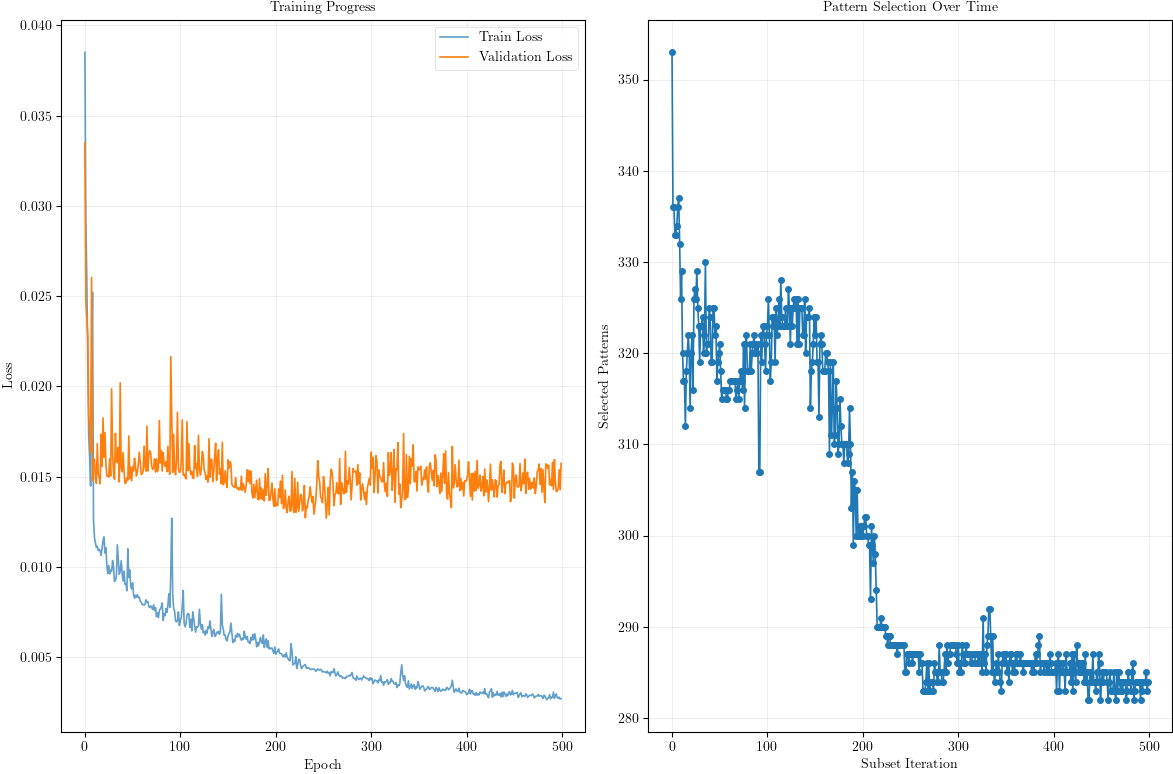

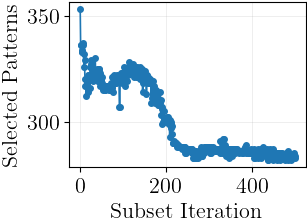

AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS
MSE: 0.0069 ± 0.0008
Root MSE: 0.0828 ± 0.0047
MAE: 0.0564 ± 0.0050
R²: 0.8099 ± 0.0221


In [62]:
# Housing prices
X = (X_train4, X_val4, X_test4)
y = (y_train4, y_val4, y_test4)

results_file = '../data/boston_housing_sasla_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=12, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
    create_sasla_selection_plot(history, saveas='boston_housing_sasla_selection')
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=12, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=12, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 12,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.5,
                'momentum': 0.8,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])

print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

#### Concrete Strength Prediction


--- Epoch 1 ---
Training subset size: 721
Epoch 1: Loss=0.0510, Val Loss=0.0540
Selected 689 out of 721 patterns
Average informativeness: 0.018851

--- Epoch 2 ---
Training subset size: 689
Epoch 2: Loss=0.0426, Val Loss=0.0382
Selected 699 out of 721 patterns
Average informativeness: 0.079406

--- Epoch 3 ---
Training subset size: 699
Epoch 3: Loss=0.0336, Val Loss=0.0296
Selected 695 out of 721 patterns
Average informativeness: 0.213730

--- Epoch 4 ---
Training subset size: 695
Epoch 4: Loss=0.0255, Val Loss=0.0224
Selected 685 out of 721 patterns
Average informativeness: 0.359260

--- Epoch 5 ---
Training subset size: 685
Epoch 5: Loss=0.0214, Val Loss=0.0217
Selected 684 out of 721 patterns
Average informativeness: 0.468309

--- Epoch 6 ---
Training subset size: 684
Epoch 6: Loss=0.0199, Val Loss=0.0192
Selected 696 out of 721 patterns
Average informativeness: 0.498032

--- Epoch 7 ---
Training subset size: 696
Epoch 7: Loss=0.0195, Val Loss=0.0193
Selected 693 out of 721 pattern

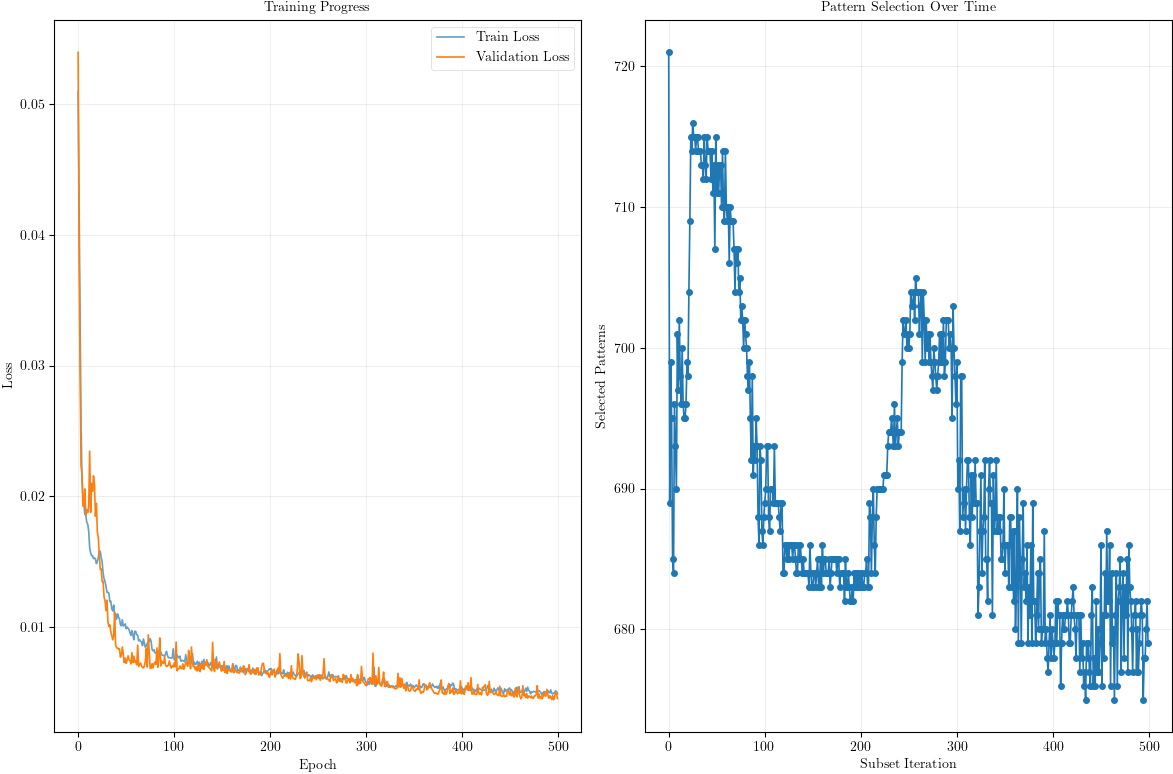

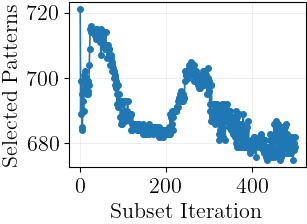

AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS
MSE: 0.0063 ± 0.0008
Root MSE: 0.0792 ± 0.0048
MAE: 0.0611 ± 0.0035
R²: 0.8424 ± 0.0199


In [63]:
# Concrete dataset
X = (X_train5, X_val5, X_test5)
y = (y_train5, y_val5, y_test5)

results_file = '../data/concrete_strength_sasla_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=8, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
    create_sasla_selection_plot(history, saveas='concrete_strength_sasla_selection')
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=8, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=8, n_epochs=500, batch_size=16, learning_rate=0.5, momentum=0.8, weight_decay=1e-05)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 8,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.5,
                'momentum': 0.8,
                'weight_decay': 0.00001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])

print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

#### Abalone Age Prediction


--- Epoch 1 ---
Training subset size: 2923
Epoch 1: Loss=0.0136, Val Loss=0.0107
Selected 2698 out of 2923 patterns
Average informativeness: 0.058260

--- Epoch 2 ---
Training subset size: 2698
Epoch 2: Loss=0.0098, Val Loss=0.0093
Selected 2681 out of 2923 patterns
Average informativeness: 0.080839

--- Epoch 3 ---
Training subset size: 2681
Epoch 3: Loss=0.0091, Val Loss=0.0092
Selected 2706 out of 2923 patterns
Average informativeness: 0.090868

--- Epoch 4 ---
Training subset size: 2706
Epoch 4: Loss=0.0090, Val Loss=0.0092
Selected 2721 out of 2923 patterns
Average informativeness: 0.092880

--- Epoch 5 ---
Training subset size: 2721
Epoch 5: Loss=0.0091, Val Loss=0.0090
Selected 2720 out of 2923 patterns
Average informativeness: 0.097170

--- Epoch 6 ---
Training subset size: 2720
Epoch 6: Loss=0.0090, Val Loss=0.0090
Selected 2720 out of 2923 patterns
Average informativeness: 0.099577

--- Epoch 7 ---
Training subset size: 2720
Epoch 7: Loss=0.0089, Val Loss=0.0092
Selected 271

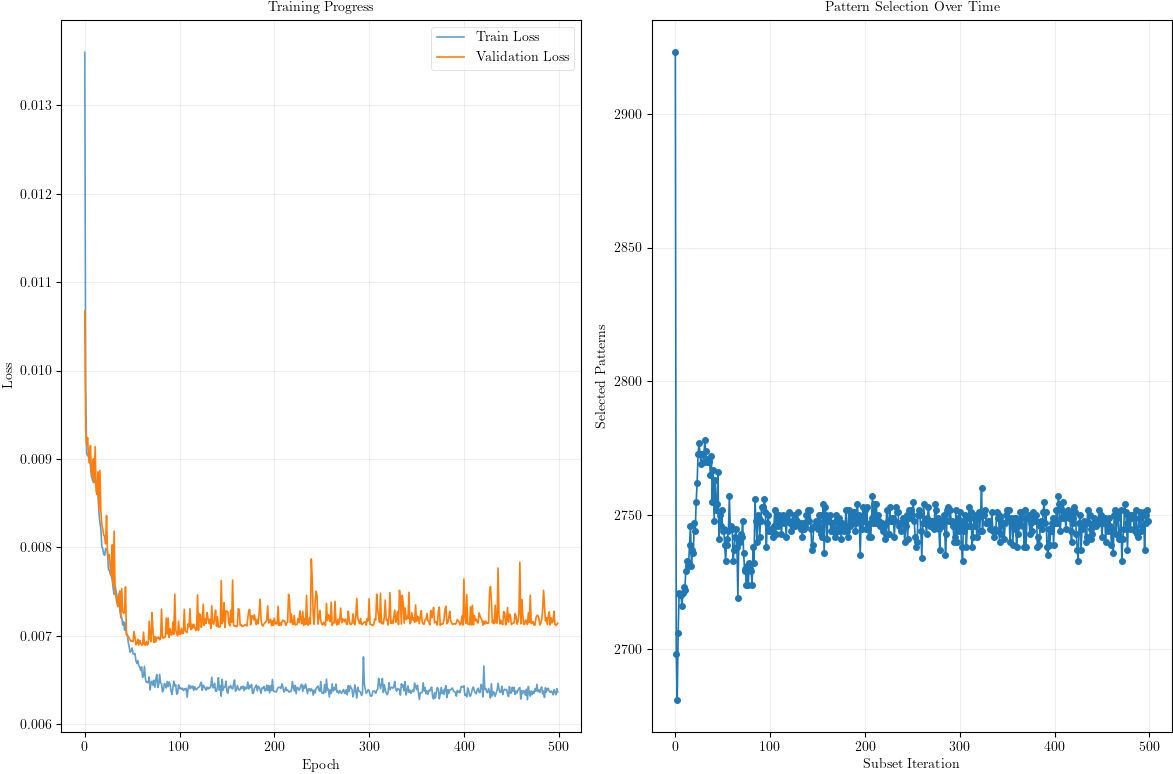

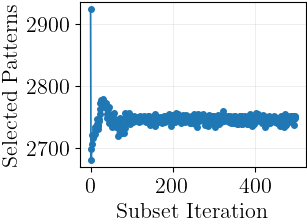

AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS
MSE: 0.0065 ± 0.0000
Root MSE: 0.0808 ± 0.0003
MAE: 0.0587 ± 0.0013
R²: 0.5268 ± 0.0031


In [64]:
# Abalone dataset
X = (X_train6, X_val6, X_test6)
y = (y_train6, y_val6, y_test6)

results_file = '../data/abalone_age_sasla_results.pkl'
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        saved_data = pickle.load(f)
    final_performances = saved_data['final_performances']
    model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=24, n_epochs=500, batch_size=16, learning_rate=0.05, momentum=0.9, weight_decay=1e-04)
    create_sasla_selection_plot(history, saveas='abalone_age_sasla_selection')
else:
    final_performances = []
    for i in tqdm.tqdm(range(9), desc="Running multiple independent runs:"):
        model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=16, n_epochs=500, batch_size=16, learning_rate=0.05, momentum=0.9, weight_decay=1e-04, v=False)
        final_performances.append(results)

    model, history, results = training_pipeline_sasla(X, y, problem="regression", hidden_units=16, n_epochs=500, batch_size=16, learning_rate=0.05, momentum=0.9, weight_decay=1e-04)
    final_performances.append(results)
    
    os.makedirs('../data', exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump({
            'final_performances': final_performances,
            'experiment_config': {
                'hidden_units': 16,
                'n_epochs': 500,
                'batch_size': 16,
                'learning_rate': 0.05,
                'momentum': 0.9,
                'weight_decay': 0.0001
            }
        }, f)
        
# Calculate and print average final performance measures
print("="*60)
print("AVERAGE SASLA PERFORMANCE ACROSS 10 RUNS")
print("="*60)
avg_mse = np.mean([p['mse'] for p in final_performances])
std_mse = np.std([p['mse'] for p in final_performances])
avg_root_mse = np.mean([p['root_mse'] for p in final_performances])
std_root_mse = np.std([p['root_mse'] for p in final_performances])
avg_mae = np.mean([p['mae'] for p in final_performances])
std_mae = np.std([p['mae'] for p in final_performances])
avg_r2 = np.mean([p['r2_score'] for p in final_performances])
std_r2 = np.std([p['r2_score'] for p in final_performances])

print(f"MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Root MSE: {avg_root_mse:.4f} ± {std_root_mse:.4f}")
print(f"MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"R²: {avg_r2:.4f} ± {std_r2:.4f}")

## Empirical Analysis

In [92]:
def load_all_results():
    """
    Load all experimental results from pickle files.
    """
    datasets = {
        'classification': ['breast_cancer', 'mobile_pricing', 'letter_recognition'],
        'regression': ['boston_housing', 'concrete_strength', 'abalone_age']
    }
    
    approaches = ['passive', 'uncertainty', 'sasla']
    
    all_results = {
        'classification': {},
        'regression': {}
    }
    
    for problem_type in ['classification', 'regression']:
        for dataset in datasets[problem_type]:
            all_results[problem_type][dataset] = {}
            
            for approach in approaches:
                filename = f'../data/{dataset}_{approach}_results.pkl'
                try:
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)
                    all_results[problem_type][dataset][approach] = data['final_performances']
                    print(f"Loaded: {filename} - {len(data['final_performances'])} runs")
                except FileNotFoundError:
                    print(f"Warning: {filename} not found")
                    all_results[problem_type][dataset][approach] = []
    
    return all_results

def extract_performance_scores(all_results, problem_type):
    """
    Extract performance scores for statistical analysis.
    """
    datasets = list(all_results[problem_type].keys())
    approaches = ['passive', 'uncertainty', 'sasla']
    
    # Initialize score matrices
    scores = {approach: [] for approach in approaches}
    
    for dataset in datasets:
        for approach in approaches:
            if problem_type == 'classification':
                # Use F1 score for classification
                dataset_scores = [run['f1_score'] for run in all_results[problem_type][dataset][approach]]
            else:
                # Use R² score for regression
                dataset_scores = [run['r2_score'] for run in all_results[problem_type][dataset][approach]]
            
            # Take mean across 10 runs for each dataset
            mean_score = np.mean(dataset_scores) if dataset_scores else 0.0
            scores[approach].append(mean_score)
    
    return scores, datasets

Creating comprehensive box plots...
Loaded: ../data/breast_cancer_passive_results.pkl - 10 runs
Loaded: ../data/breast_cancer_uncertainty_results.pkl - 10 runs
Loaded: ../data/breast_cancer_sasla_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_passive_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_uncertainty_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_sasla_results.pkl - 10 runs
Loaded: ../data/letter_recognition_passive_results.pkl - 10 runs
Loaded: ../data/letter_recognition_uncertainty_results.pkl - 10 runs
Loaded: ../data/letter_recognition_sasla_results.pkl - 10 runs
Loaded: ../data/boston_housing_passive_results.pkl - 10 runs
Loaded: ../data/boston_housing_uncertainty_results.pkl - 10 runs
Loaded: ../data/boston_housing_sasla_results.pkl - 10 runs
Loaded: ../data/concrete_strength_passive_results.pkl - 10 runs
Loaded: ../data/concrete_strength_uncertainty_results.pkl - 10 runs
Loaded: ../data/concrete_strength_sasla_results.pkl - 10 runs
Loaded: ../data/abalo

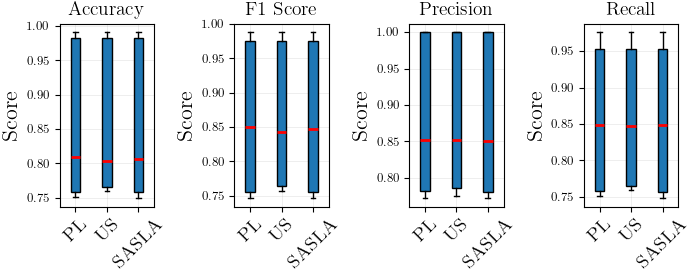

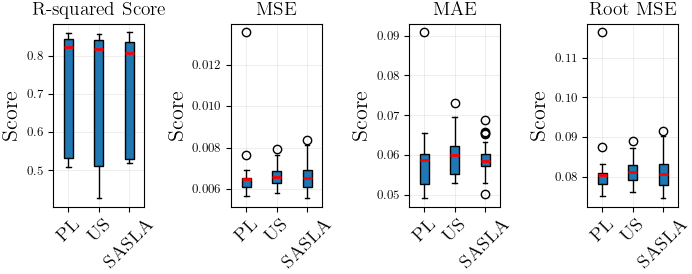

In [107]:
def create_comprehensive_boxplots(all_results):
    # Define metrics for each problem type
    classification_metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    regression_metrics = ['r2_score', 'mse', 'mae', 'root_mse']
    
    algorithms = ['passive', 'uncertainty', 'sasla']
    algorithm_labels = ['PL', 'US', 'SASLA']
    
    # Classification boxplots - all 4 metrics in one row
    fig, axes = plt.subplots(1, 4, figsize=(text_width_inches, 3))
    
    # Prepare classification results dictionary
    classification_results = {}
    datasets_class = ['breast_cancer', 'mobile_pricing', 'letter_recognition']
    
    for metric in classification_metrics:
        classification_results[metric] = {alg: [] for alg in algorithms}
        
        for dataset in datasets_class:
            for alg in algorithms:
                results = all_results['classification'][dataset][alg]
                if results:
                    metric_values = [run[metric] for run in results]
                    classification_results[metric][alg].extend(metric_values)
    
    # Create classification box plots
    for i, metric in enumerate(classification_metrics):
        ax = axes[i]
        
        # Prepare data for box plot
        data_to_plot = [classification_results[metric][alg] for alg in algorithms]
        
        # Create box plot
        box_plot = ax.boxplot(data_to_plot, tick_labels=algorithm_labels, patch_artist=True)
        
        for median_line in box_plot['medians']:
            median_line.set_color('red')
            median_line.set_linewidth(2)
        
        # Set title and labels
        metric_name = metric.replace('_', ' ').title()
        if metric == 'f1_score':
            metric_name = 'F1 Score'
        
        ax.set_title(f'{metric_name}', fontweight='bold', fontsize=14)
        ax.set_ylabel('Score', fontsize=16)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=14)
    plt.tight_layout()
    plt.savefig('../report/plots/classification_boxplots.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    # Regression boxplots - all 4 metrics in one row
    fig, axes = plt.subplots(1, 4, figsize=(text_width_inches, 3))
    
    # Prepare regression results dictionary
    regression_results = {}
    datasets_reg = ['boston_housing', 'concrete_strength', 'abalone_age']
    
    for metric in regression_metrics:
        regression_results[metric] = {alg: [] for alg in algorithms}
        
        for dataset in datasets_reg:
            for alg in algorithms:
                results = all_results['regression'][dataset][alg]
                if results:
                    metric_values = [run[metric] for run in results]
                    regression_results[metric][alg].extend(metric_values)
    
    # Create regression box plots
    for i, metric in enumerate(regression_metrics):
        ax = axes[i]
        
        # Prepare data for box plot
        data_to_plot = [regression_results[metric][alg] for alg in algorithms]
        
        # Create box plot
        box_plot = ax.boxplot(data_to_plot, tick_labels=algorithm_labels, patch_artist=True)
        
        for median_line in box_plot['medians']:
            median_line.set_color('red')
            median_line.set_linewidth(2)
        
        # Set title and labels
        metric_name = metric.replace('_', ' ').title()
        if metric == 'r2_score':
            metric_name = 'R-squared Score'
        elif metric == 'mse':
            metric_name = 'MSE'
        elif metric == 'mae':
            metric_name = 'MAE'
        elif metric == 'root_mse':
            metric_name = 'Root MSE'
        
        ax.set_title(f'{metric_name}', fontweight='bold', fontsize=14)
        ax.set_ylabel('Score', fontsize=16)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=14)

    plt.tight_layout()
    plt.savefig('../report/plots/regression_boxplots.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Execute the analysis
print("Creating comprehensive box plots...")
all_results = load_all_results()
create_comprehensive_boxplots(all_results)

In [139]:
def create_critical_difference_plot_three_algorithms(scores, algorithm_names, problem_type="Classification", saveas=None, alpha=0.05):
    # Convert to numpy arrays
    score_arrays = [np.array(scores[name]) for name in algorithm_names]
    n_datasets = len(score_arrays[0])
    k_algorithms = len(algorithm_names)
    
    # Calculate ranks for each dataset
    ranks_matrix = []
    for i in range(n_datasets):
        dataset_scores = [score_arrays[j][i] for j in range(k_algorithms)]
        # Use negative scores for ranking
        dataset_ranks = rankdata([-score for score in dataset_scores])
        ranks_matrix.append(dataset_ranks)
    
    ranks_matrix = np.array(ranks_matrix)
    
    # Calculate mean ranks
    mean_ranks = pd.Series([np.mean(ranks_matrix[:, i]) for i in range(k_algorithms)], 
                          index=algorithm_names)
    
    # Perform pairwise Wilcoxon signed-rank tests
    p_values = np.ones((k_algorithms, k_algorithms))
    for i in range(k_algorithms):
        for j in range(i+1, k_algorithms):
            try:
                stat, p_val = wilcoxon(score_arrays[i], score_arrays[j])
                p_values[i, j] = p_val
                p_values[j, i] = p_val
            except ValueError:
                # Handle case where differences are all zero
                p_values[i, j] = 1.0
                p_values[j, i] = 1.0
    
    # Create significance matrix
    sig_matrix = pd.DataFrame(p_values, index=algorithm_names, columns=algorithm_names)
    
    # Calculate critical difference for Nemenyi test
    q_alpha = 2.344 if alpha == 0.05 else 2.569  # For k=3 algorithms
    critical_difference = q_alpha * np.sqrt(k_algorithms * (k_algorithms + 1) / (6 * n_datasets))
    
    # Create the critical difference plot
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "legend.fontsize": 9,
        "savefig.bbox": "tight",
        "savefig.format": "pdf",
        "savefig.dpi": 300
    })
    
    fig, ax = plt.subplots(figsize=(column_width_inches*1.4, 3))
    
    sp.critical_difference_diagram(
        ranks=mean_ranks,
        sig_matrix=sig_matrix,
        ax=ax,
        label_fmt_left='{label}\n({rank:.2f})',
        label_fmt_right='({rank:.2f})\n{label}',
        color_palette=['black', 'black', 'black'],
        label_props={'fontsize': 10, 'fontweight': 'bold'},
        text_h_margin=0.15
    )
    
    # Add title with critical difference
    metric = "F1 Score" if problem_type == "Classification" else "R-Squared Score"
    ax.set_title(f'{problem_type} Performance Comparison ({metric})\nCritical Difference = {critical_difference:.3f}',
                fontsize=11, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if saveas:
        plt.savefig(f'../report/plots/{saveas}.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return mean_ranks, sig_matrix, critical_difference

def perform_pairwise_analysis(scores, algorithm_names, problem_type):
    print(f"\n{'='*60}")
    print(f"DETAILED STATISTICAL ANALYSIS - {problem_type.upper()}")
    print(f"{'='*60}")
    
    score_arrays = [np.array(scores[name]) for name in algorithm_names]
    metric = "F1 Score" if problem_type == "Classification" else "R² Score"
    
    # Print descriptive statistics
    print(f"\nDescriptive Statistics ({metric}):")
    print("-" * 50)
    for i, name in enumerate(algorithm_names):
        mean_score = np.mean(score_arrays[i])
        std_score = np.std(score_arrays[i])
        print(f"{name:20}: {mean_score:.4f} ± {std_score:.4f}")
    
    # Pairwise comparisons
    print(f"\nPairwise Wilcoxon Signed-Rank Tests:")
    print("-" * 50)
    
    for i in range(len(algorithm_names)):
        for j in range(i+1, len(algorithm_names)):
            try:
                stat, p_val = wilcoxon(score_arrays[i], score_arrays[j])
                effect_size = np.mean(score_arrays[i]) - np.mean(score_arrays[j])
                
                print(f"{algorithm_names[i]} vs {algorithm_names[j]}:")
                print(f"  p-value: {p_val:.6f}")
                print(f"  Effect size: {effect_size:+.4f}")
                print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")
                print()
            except ValueError as e:
                print(f"{algorithm_names[i]} vs {algorithm_names[j]}: Error - {e}")

def create_performance_summary_table(all_results):
    datasets_class = ['breast_cancer', 'mobile_pricing', 'letter_recognition']
    datasets_reg = ['boston_housing', 'concrete_strength', 'abalone_age']
    approaches = ['passive', 'uncertainty', 'sasla']
    
    print(f"\n{'='*80}")
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    # Classification results
    print(f"\nCLASSIFICATION RESULTS (F1 Score)")
    print("-" * 70)
    print(f"{'Dataset':<20} {'Passive':<15} {'Uncertainty':<15} {'SASLA':<15}")
    print("-" * 70)
    
    for dataset in datasets_class:
        row = f"{dataset:<20}"
        for approach in approaches:
            results = all_results['classification'][dataset][approach]
            if results:
                mean_f1 = np.mean([r['f1_score'] for r in results])
                std_f1 = np.std([r['f1_score'] for r in results])
                row += f"{mean_f1:.3f}±{std_f1:.3f}   "
            else:
                row += f"{'N/A':<15}"
        print(row)
    
    # Regression results
    print(f"\nREGRESSION RESULTS (R² Score)")
    print("-" * 70)
    print(f"{'Dataset':<20} {'Passive':<15} {'Uncertainty':<15} {'SASLA':<15}")
    print("-" * 70)
    
    for dataset in datasets_reg:
        row = f"{dataset:<20}"
        for approach in approaches:
            results = all_results['regression'][dataset][approach]
            if results:
                mean_r2 = np.mean([r['r2_score'] for r in results])
                std_r2 = np.std([r['r2_score'] for r in results])
                row += f"{mean_r2:.3f}±{std_r2:.3f}   "
            else:
                row += f"{'N/A':<15}"
        print(row)

Loaded: ../data/breast_cancer_passive_results.pkl - 10 runs
Loaded: ../data/breast_cancer_uncertainty_results.pkl - 10 runs
Loaded: ../data/breast_cancer_sasla_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_passive_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_uncertainty_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_sasla_results.pkl - 10 runs
Loaded: ../data/letter_recognition_passive_results.pkl - 10 runs
Loaded: ../data/letter_recognition_uncertainty_results.pkl - 10 runs
Loaded: ../data/letter_recognition_sasla_results.pkl - 10 runs
Loaded: ../data/boston_housing_passive_results.pkl - 10 runs
Loaded: ../data/boston_housing_uncertainty_results.pkl - 10 runs
Loaded: ../data/boston_housing_sasla_results.pkl - 10 runs
Loaded: ../data/concrete_strength_passive_results.pkl - 10 runs
Loaded: ../data/concrete_strength_uncertainty_results.pkl - 10 runs
Loaded: ../data/concrete_strength_sasla_results.pkl - 10 runs
Loaded: ../data/abalone_age_passive_results.pkl - 10 runs

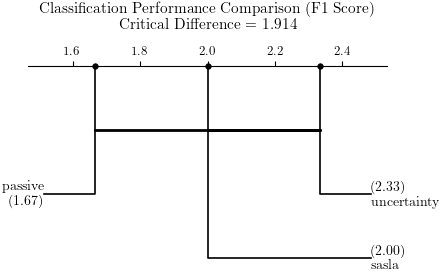


DETAILED STATISTICAL ANALYSIS - REGRESSION

Descriptive Statistics (R² Score):
--------------------------------------------------
passive             : 0.7268 ± 0.1409
uncertainty         : 0.7169 ± 0.1630
sasla               : 0.7263 ± 0.1417

Pairwise Wilcoxon Signed-Rank Tests:
--------------------------------------------------
passive vs uncertainty:
  p-value: 0.750000
  Effect size: +0.0099
  Significant: No

passive vs sasla:
  p-value: 0.750000
  Effect size: +0.0004
  Significant: No

uncertainty vs sasla:
  p-value: 1.000000
  Effect size: -0.0095
  Significant: No



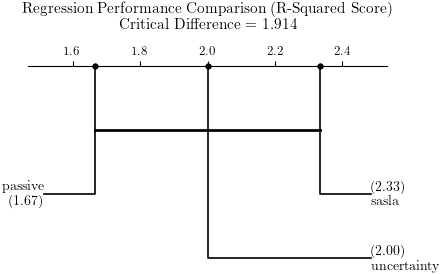

In [140]:
all_results = load_all_results()
create_performance_summary_table(all_results)

class_scores, class_datasets = extract_performance_scores(all_results, 'classification')
algorithm_names = ['passive', 'uncertainty', 'sasla']
# Perform statistcal analysis
perform_pairwise_analysis(class_scores, algorithm_names, 'Classification')
# Create critical difference plot for classification
class_mean_ranks, class_sig_matrix, class_cd = create_critical_difference_plot_three_algorithms(
    class_scores, algorithm_names, 'Classification', 'classification_critical_difference'
)

reg_scores, reg_datasets = extract_performance_scores(all_results, 'regression')
# Perform statistical analysis
perform_pairwise_analysis(reg_scores, algorithm_names, 'Regression')
# Create critical difference plot for regression
reg_mean_ranks, reg_sig_matrix, reg_cd = create_critical_difference_plot_three_algorithms(
    reg_scores, algorithm_names, 'Regression', 'regression_critical_difference'
)

In [32]:
from scipy.stats import friedmanchisquare
import numpy as np
import pandas as pd
from scipy.stats import rankdata

def friedman_nemenyi_test(all_results, problem_type='classification', alpha=0.05):
    """
    Perform Friedman test followed by Nemenyi post-hoc test for comparing 3 algorithms.
    
    Args:
        all_results: Dictionary containing experimental results
        problem_type: 'classification' or 'regression'
        alpha: Significance level (default 0.05)
    
    Returns:
        friedman_stats, nemenyi_results, critical_difference
    """
    
    # Extract performance scores
    datasets = list(all_results[problem_type].keys())
    algorithms = ['passive', 'uncertainty', 'sasla']
    
    # Create performance matrix: [n_datasets x n_algorithms]
    performance_matrix = []
    
    for dataset in datasets:
        dataset_scores = []
        for algorithm in algorithms:
            results = all_results[problem_type][dataset][algorithm]
            if problem_type == 'classification':
                mean_score = np.mean([r['f1_score'] for r in results])
            else:
                mean_score = np.mean([r['r2_score'] for r in results])
            dataset_scores.append(mean_score)
        performance_matrix.append(dataset_scores)
    
    performance_matrix = np.array(performance_matrix)
    n_datasets, n_algorithms = performance_matrix.shape
    
    print(f"\n{'='*60}")
    print(f"FRIEDMAN TEST - {problem_type.upper()}")
    print(f"{'='*60}")
    
    # Display performance matrix
    df_performance = pd.DataFrame(performance_matrix, 
                                 columns=algorithms, 
                                 index=datasets)
    print(f"\nPerformance Matrix:")
    print(df_performance.round(4))
    
    # Calculate ranks for each dataset (1 = best, 3 = worst)
    # For performance metrics, higher is better, so we rank in descending order
    ranks_matrix = np.zeros_like(performance_matrix)
    for i in range(n_datasets):
        # Use negative scores to rank (so highest score gets rank 1)
        ranks_matrix[i] = rankdata(-performance_matrix[i])
    
    print(f"\nRanks Matrix (1=best, {n_algorithms}=worst):")
    df_ranks = pd.DataFrame(ranks_matrix, 
                           columns=algorithms, 
                           index=datasets)
    print(df_ranks)
    
    # Calculate mean ranks
    mean_ranks = np.mean(ranks_matrix, axis=0)
    print(f"\nMean Ranks:")
    for i, alg in enumerate(algorithms):
        print(f"  {alg}: {mean_ranks[i]:.3f}")
    
    # Perform Friedman test
    # Prepare data for scipy friedmanchisquare (each algorithm's ranks across datasets)
    alg_ranks = [ranks_matrix[:, i] for i in range(n_algorithms)]
    
    friedman_stat, friedman_p = friedmanchisquare(*alg_ranks)
    
    print(f"\nFriedman Test Results:")
    print(f"  Chi-square statistic: {friedman_stat:.4f}")
    print(f"  p-value: {friedman_p:.6f}")
    print(f"  Significant difference: {'Yes' if friedman_p < alpha else 'No'}")
    
    # If Friedman test is significant, perform Nemenyi post-hoc test
    nemenyi_results = None
    critical_difference = None
    
    if friedman_p < alpha:
        print(f"\n{'='*60}")
        print("NEMENYI POST-HOC TEST")
        print(f"{'='*60}")
        
        # Calculate critical difference for Nemenyi test
        # q_alpha values for k=3 algorithms at alpha=0.05 and 0.10
        q_alpha = 2.344 if alpha == 0.05 else 2.052  # Two-tailed critical values
        critical_difference = q_alpha * np.sqrt(n_algorithms * (n_algorithms + 1) / (6 * n_datasets))
        
        print(f"Critical Difference (CD): {critical_difference:.4f}")
        print(f"Alpha level: {alpha}")
        
        # Perform pairwise comparisons
        nemenyi_results = {}
        print(f"\nPairwise Comparisons:")
        
        for i in range(n_algorithms):
            for j in range(i + 1, n_algorithms):
                rank_diff = abs(mean_ranks[i] - mean_ranks[j])
                is_significant = rank_diff > critical_difference
                
                better_alg = algorithms[i] if mean_ranks[i] < mean_ranks[j] else algorithms[j]
                worse_alg = algorithms[j] if mean_ranks[i] < mean_ranks[j] else algorithms[i]
                
                nemenyi_results[f"{algorithms[i]}_vs_{algorithms[j]}"] = {
                    'rank_difference': rank_diff,
                    'critical_difference': critical_difference,
                    'significant': is_significant,
                    'better_algorithm': better_alg if is_significant else 'No significant difference'
                }
                
                print(f"  {algorithms[i]} vs {algorithms[j]}:")
                print(f"    Rank difference: {rank_diff:.4f}")
                print(f"    Significant: {'Yes' if is_significant else 'No'}")
                if is_significant:
                    print(f"    Better algorithm: {better_alg}")
                print()
        
        # Summary of significant differences
        print(f"Summary of Significant Differences (α = {alpha}):")
        significant_pairs = [(k, v) for k, v in nemenyi_results.items() if v['significant']]
        
        if significant_pairs:
            for pair_name, result in significant_pairs:
                print(f"  {pair_name.replace('_vs_', ' > ')}: {result['better_algorithm']} significantly better")
        else:
            print("  No significant pairwise differences found")
    
    else:
        print(f"\nFriedman test not significant (p = {friedman_p:.6f})")
        print("Skipping post-hoc analysis - no significant differences between algorithms")
    
    return {
        'friedman_statistic': friedman_stat,
        'friedman_p_value': friedman_p,
        'mean_ranks': dict(zip(algorithms, mean_ranks)),
        'performance_matrix': df_performance,
        'ranks_matrix': df_ranks,
        'nemenyi_results': nemenyi_results,
        'critical_difference': critical_difference,
        'significant_pairs': len([v for v in (nemenyi_results or {}).values() if v['significant']])
    }

def comprehensive_statistical_analysis(all_results):
    """
    Perform comprehensive statistical analysis for both classification and regression.
    """
    print(f"{'='*80}")
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print(f"{'='*80}")
    
    results = {}
    
    # Analyze classification results
    print(f"\n🔍 CLASSIFICATION ANALYSIS")
    classification_results = friedman_nemenyi_test(all_results, 'classification')
    results['classification'] = classification_results
    
    # Analyze regression results  
    print(f"\n🔍 REGRESSION ANALYSIS")
    regression_results = friedman_nemenyi_test(all_results, 'regression')
    results['regression'] = regression_results
    
    # Overall summary
    print(f"\n{'='*80}")
    print("OVERALL SUMMARY")
    print(f"{'='*80}")
    
    for problem_type, analysis in results.items():
        print(f"\n{problem_type.upper()}:")
        print(f"  Friedman test p-value: {analysis['friedman_p_value']:.6f}")
        print(f"  Significant overall difference: {'Yes' if analysis['friedman_p_value'] < 0.05 else 'No'}")
        
        if analysis['nemenyi_results']:
            print(f"  Significant pairwise differences: {analysis['significant_pairs']}")
            
            # Rank the algorithms
            mean_ranks = analysis['mean_ranks']
            sorted_algorithms = sorted(mean_ranks.items(), key=lambda x: x[1])
            print(f"  Algorithm ranking (best to worst):")
            for rank, (alg, mean_rank) in enumerate(sorted_algorithms, 1):
                print(f"    {rank}. {alg} (mean rank: {mean_rank:.3f})")
        else:
            print(f"  Post-hoc analysis: Not performed (Friedman test not significant)")
    
    return results

# Execute the comprehensive analysis
print("Performing comprehensive statistical analysis...")
statistical_results = comprehensive_statistical_analysis(all_results)

Performing comprehensive statistical analysis...
COMPREHENSIVE STATISTICAL ANALYSIS

🔍 CLASSIFICATION ANALYSIS

FRIEDMAN TEST - CLASSIFICATION

Performance Matrix:
                    passive  uncertainty   sasla
breast_cancer        0.9781       0.9768  0.9818
mobile_pricing       0.8461       0.8408  0.8457
letter_recognition   0.7530       0.7614  0.7524

Ranks Matrix (1=best, 3=worst):
                    passive  uncertainty  sasla
breast_cancer           2.0          3.0    1.0
mobile_pricing          1.0          3.0    2.0
letter_recognition      2.0          1.0    3.0

Mean Ranks:
  passive: 1.667
  uncertainty: 2.333
  sasla: 2.000

Friedman Test Results:
  Chi-square statistic: 0.6667
  p-value: 0.716531
  Significant difference: No

Friedman test not significant (p = 0.716531)
Skipping post-hoc analysis - no significant differences between algorithms

🔍 REGRESSION ANALYSIS

FRIEDMAN TEST - REGRESSION

Performance Matrix:
                   passive  uncertainty   sasla
bost

In [41]:
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

def calculate_wins_ties_losses_vs_baseline(all_results, baseline='passive'):
    """
    Calculate wins, ties, and losses for each algorithm against the baseline (passive learning).
    Uses paired t-tests to compare performance across multiple runs.
    """
    # Active learning methods to compare against baseline
    active_methods = ['uncertainty', 'sasla']
    
    # Performance measures for each problem type
    classification_measures = ['f1_score', 'accuracy', 'precision', 'recall']
    regression_measures = ['r2_score', 'mae', 'mse', 'root_mse']
    
    # Initialize results tracking
    comparison_results = {method: {'wins': 0, 'ties': 0, 'losses': 0, 'details': []} 
                         for method in active_methods}
    
    print(f"\n{'='*80}")
    print(f"WINS/TIES/LOSSES ANALYSIS AGAINST BASELINE ({baseline.upper()})")
    print(f"{'='*80}")
    
    # For each problem type
    for problem_type in ['classification', 'regression']:
        datasets = list(all_results[problem_type].keys())
        measures = classification_measures if problem_type == 'classification' else regression_measures
        
        print(f"\n{problem_type.upper()} DATASETS:")
        print("-" * 50)
        
        for dataset in datasets:
            print(f"\nAnalyzing {dataset}...")
            
            # Get baseline results
            baseline_results = all_results[problem_type][dataset][baseline]
            if not baseline_results:
                print(f"  Warning: No baseline results for {dataset}")
                continue
            
            # For each performance measure
            for measure in measures:
                print(f"  Measure: {measure}")
                
                # Check if measure exists in baseline
                if measure not in baseline_results[0]:
                    print(f"    Warning: {measure} not found in baseline results")
                    continue
                
                # Extract baseline performance values
                baseline_values = [run[measure] for run in baseline_results]
                
                # Compare each active method against baseline
                for method in active_methods:
                    method_results = all_results[problem_type][dataset][method]
                    
                    if not method_results:
                        print(f"    Warning: No results for {method}")
                        continue
                    
                    if measure not in method_results[0]:
                        print(f"    Warning: {measure} not found for {method}")
                        continue
                    
                    # Extract method performance values
                    method_values = [run[measure] for run in method_results]
                    
                    # Ensure we have the same number of runs
                    min_runs = min(len(baseline_values), len(method_values))
                    if min_runs < len(baseline_values) or min_runs < len(method_values):
                        print(f"    Warning: Mismatched run counts for {method} vs {baseline}")
                        baseline_values_paired = baseline_values[:min_runs]
                        method_values_paired = method_values[:min_runs]
                    else:
                        baseline_values_paired = baseline_values
                        method_values_paired = method_values
                    
                    # Perform paired t-test
                    try:
                        # Determine test direction based on measure type
                        higher_is_better = measure in ['f1_score', 'accuracy', 'precision', 'recall', 'r2_score']
                        
                        # Calculate differences (method - baseline)
                        differences = np.array(method_values_paired) - np.array(baseline_values_paired)
                        
                        # Perform one-tailed t-test
                        if higher_is_better:
                            # For measures where higher is better, test if method > baseline
                            t_stat, p_val = ttest_rel(method_values_paired, baseline_values_paired, 
                                                    alternative='greater')
                            comparison_direction = "higher is better"
                        else:
                            # For measures where lower is better, test if method < baseline
                            t_stat, p_val = ttest_rel(method_values_paired, baseline_values_paired, 
                                                    alternative='less')
                            comparison_direction = "lower is better"
                        
                        # Determine result
                        alpha = 0.05
                        if p_val < alpha:
                            result = 'Win'
                            comparison_results[method]['wins'] += 1
                        else:
                            # Check if significantly worse (opposite direction)
                            if higher_is_better:
                                t_stat_worse, p_val_worse = ttest_rel(method_values_paired, baseline_values_paired, 
                                                                    alternative='less')
                            else:
                                t_stat_worse, p_val_worse = ttest_rel(method_values_paired, baseline_values_paired, 
                                                                    alternative='greater')
                            
                            if p_val_worse < alpha:
                                result = 'Loss'
                                comparison_results[method]['losses'] += 1
                            else:
                                result = 'Tie'
                                comparison_results[method]['ties'] += 1
                        
                        # Calculate effect size (mean difference)
                        mean_baseline = np.mean(baseline_values_paired)
                        mean_method = np.mean(method_values_paired)
                        effect_size = mean_method - mean_baseline
                        
                        print(f"    {method} vs {baseline}:")
                        print(f"      {baseline}: {mean_baseline:.4f}")
                        print(f"      {method}: {mean_method:.4f}")
                        print(f"      Effect size: {effect_size:+.4f}")
                        print(f"      t-statistic: {t_stat:.4f}")
                        print(f"      p-value: {p_val:.6f}")
                        print(f"      Result: {result}")
                        
                        # Store detailed results
                        comparison_results[method]['details'].append({
                            'dataset': dataset,
                            'problem_type': problem_type,
                            'measure': measure,
                            'result': result,
                            'p_value': p_val,
                            'effect_size': effect_size,
                            'baseline_mean': mean_baseline,
                            'method_mean': mean_method,
                            'comparison_direction': comparison_direction
                        })
                        
                    except Exception as e:
                        print(f"    Error in t-test for {method} vs {baseline}: {e}")
                        comparison_results[method]['ties'] += 1  # Default to tie on error
    
    return comparison_results

def create_baseline_comparison_summary(comparison_results, baseline='passive'):
    """
    Create a comprehensive summary of wins/ties/losses against baseline.
    """
    print(f"\n{'='*80}")
    print(f"SUMMARY: ACTIVE LEARNING vs {baseline.upper()} BASELINE")
    print(f"{'='*80}")
    
    # Overall summary table
    print(f"\nOVERALL COMPARISON SUMMARY")
    print("-" * 60)
    print(f"{'Method':<15} {'Wins':<10} {'Ties':<10} {'Losses':<10} {'Win Rate':<10}")
    print("-" * 60)
    
    for method in ['uncertainty', 'sasla']:
        wins = comparison_results[method]['wins']
        ties = comparison_results[method]['ties']
        losses = comparison_results[method]['losses']
        total_comparisons = wins + ties + losses
        win_rate = (wins / total_comparisons) * 100 if total_comparisons > 0 else 0
        
        print(f"{method:<15} {wins:<10} {ties:<10} {losses:<10} {win_rate:<10.1f}%")
    
    # Problem-specific breakdown
    problem_summary = {
        'classification': {method: {'wins': 0, 'ties': 0, 'losses': 0} 
                          for method in ['uncertainty', 'sasla']},
        'regression': {method: {'wins': 0, 'ties': 0, 'losses': 0} 
                      for method in ['uncertainty', 'sasla']}
    }
    
    # Aggregate by problem type
    for method in ['uncertainty', 'sasla']:
        for detail in comparison_results[method]['details']:
            problem_type = detail['problem_type']
            result = detail['result']
            
            if result == 'Win':
                problem_summary[problem_type][method]['wins'] += 1
            elif result == 'Loss':
                problem_summary[problem_type][method]['losses'] += 1
            else:
                problem_summary[problem_type][method]['ties'] += 1
    
    # Display by problem type
    for problem_type in ['classification', 'regression']:
        print(f"\n{problem_type.upper()} RESULTS")
        print("-" * 60)
        print(f"{'Method':<15} {'Wins':<10} {'Ties':<10} {'Losses':<10} {'Win Rate':<10}")
        print("-" * 60)
        
        for method in ['uncertainty', 'sasla']:
            wins = problem_summary[problem_type][method]['wins']
            ties = problem_summary[problem_type][method]['ties']
            losses = problem_summary[problem_type][method]['losses']
            total = wins + ties + losses
            win_rate = (wins / total) * 100 if total > 0 else 0
            print(f"{method:<15} {wins:<10} {ties:<10} {losses:<10} {win_rate:<10.1f}%")
    
    # Detailed breakdown by dataset and measure
    print(f"\n{'='*80}")
    print("DETAILED BREAKDOWN BY DATASET AND MEASURE")
    print(f"{'='*80}")
    
    for method in ['uncertainty', 'sasla']:
        print(f"\n{method.upper()} vs {baseline.upper()}:")
        print("-" * 60)
        
        # Group by dataset
        dataset_results = {}
        for detail in comparison_results[method]['details']:
            dataset = detail['dataset']
            if dataset not in dataset_results:
                dataset_results[dataset] = []
            dataset_results[dataset].append(detail)
        
        for dataset, results in dataset_results.items():
            print(f"\n  {dataset}:")
            wins = len([r for r in results if r['result'] == 'Win'])
            ties = len([r for r in results if r['result'] == 'Tie'])
            losses = len([r for r in results if r['result'] == 'Loss'])
            print(f"    Overall: {wins}W/{ties}T/{losses}L")
            
            for result in results:
                result_symbol = 'W' if result['result'] == 'Win' else ('L' if result['result'] == 'Loss' else 'T')
                print(f"    {result['measure']:<12}: {result_symbol} "
                      f"(p={result['p_value']:.4f}, effect={result['effect_size']:+.4f})")
    
    # Statistical significance summary
    print(f"\n{'='*80}")
    print("STATISTICAL SIGNIFICANCE SUMMARY")
    print(f"{'='*80}")
    
    for method in ['uncertainty', 'sasla']:
        significant_wins = len([d for d in comparison_results[method]['details'] 
                              if d['result'] == 'Win'])
        significant_losses = len([d for d in comparison_results[method]['details'] 
                                if d['result'] == 'Loss'])
        total_comparisons = len(comparison_results[method]['details'])
        
        print(f"\n{method.upper()}:")
        print(f"  Significantly better than {baseline}: {significant_wins}/{total_comparisons}")
        print(f"  Significantly worse than {baseline}: {significant_losses}/{total_comparisons}")
        print(f"  No significant difference: {total_comparisons - significant_wins - significant_losses}/{total_comparisons}")
    
    return problem_summary

# Execute the baseline comparison analysis
print("Loading experimental results...")
all_results = load_all_results()

# Perform baseline comparison
baseline_comparison = calculate_wins_ties_losses_vs_baseline(all_results, baseline='passive')
baseline_summary = create_baseline_comparison_summary(baseline_comparison, baseline='passive')

# Additional analysis: Count expected totals
print(f"\n{'='*80}")
print("EXPECTED TOTALS VERIFICATION")
print(f"{'='*80}")

classification_datasets = 3
regression_datasets = 3
classification_measures = 4  # f1_score, accuracy, precision, recall
regression_measures = 4     # r2_score, mae, mse, root_mse

expected_total_per_method = (classification_datasets * classification_measures + 
                           regression_datasets * regression_measures)

print(f"Expected comparisons per method: {expected_total_per_method}")
print(f"  Classification: {classification_datasets} datasets × {classification_measures} measures = {classification_datasets * classification_measures}")
print(f"  Regression: {regression_datasets} datasets × {regression_measures} measures = {regression_datasets * regression_measures}")

for method in ['uncertainty', 'sasla']:
    actual_total = (baseline_comparison[method]['wins'] + 
                   baseline_comparison[method]['ties'] + 
                   baseline_comparison[method]['losses'])
    print(f"\n{method}: {actual_total}/{expected_total_per_method} comparisons")
    print(f"  Match: {'Yes' if actual_total == expected_total_per_method else 'No'}")

Loading experimental results...
Loaded: ../data/breast_cancer_passive_results.pkl - 10 runs
Loaded: ../data/breast_cancer_uncertainty_results.pkl - 10 runs
Loaded: ../data/breast_cancer_sasla_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_passive_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_uncertainty_results.pkl - 10 runs
Loaded: ../data/mobile_pricing_sasla_results.pkl - 10 runs
Loaded: ../data/letter_recognition_passive_results.pkl - 10 runs
Loaded: ../data/letter_recognition_uncertainty_results.pkl - 10 runs
Loaded: ../data/letter_recognition_sasla_results.pkl - 10 runs
Loaded: ../data/boston_housing_passive_results.pkl - 10 runs
Loaded: ../data/boston_housing_uncertainty_results.pkl - 10 runs
Loaded: ../data/boston_housing_sasla_results.pkl - 10 runs
Loaded: ../data/concrete_strength_passive_results.pkl - 10 runs
Loaded: ../data/concrete_strength_uncertainty_results.pkl - 10 runs
Loaded: ../data/concrete_strength_sasla_results.pkl - 10 runs
Loaded: ../data/abalone_a